# Определение стоимости автомобилей

Сервис по продаже автомобилей с пробегом «Не бит, не крашен» разрабатывает приложение для привлечения новых клиентов. В нём можно быстро узнать рыночную стоимость своего автомобиля. В вашем распоряжении исторические данные: технические характеристики, комплектации и цены автомобилей. Вам нужно построить модель для определения стоимости. 

Заказчику важны:

- качество предсказания;
- скорость предсказания;
- время обучения.

In [1]:
#pip install phik shap lightgbm catboost xgboost pandas==2.2.2 scikit-learn==1.5.1. matplotlib==3.7.3 seaborn==0.13.2 -q

In [2]:
import pandas as pd
import numpy as np
import scipy.stats as st
import matplotlib.pyplot as plt
import seaborn as sns
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor
from xgboost import XGBRegressor
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from sklearn.svm import LinearSVR
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import AdaBoostRegressor
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import DecisionTreeRegressor
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn import metrics
from sklearn import tree
from sklearn.datasets import make_classification
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.utils.multiclass import type_of_target
from sklearn.inspection import permutation_importance

from sklearn.metrics import (
    accuracy_score, 
    confusion_matrix, 
    r2_score,
    precision_score,
    recall_score, 
    f1_score, 
    roc_curve, 
    roc_auc_score, 
    fbeta_score, 
    make_scorer, 
    root_mean_squared_error, 
    mean_squared_error, 
    mean_absolute_error
)

from sklearn.model_selection import (
    train_test_split, 
    cross_val_score, 
    GridSearchCV, 
    RandomizedSearchCV,
    KFold
) 

from sklearn.preprocessing import (
    StandardScaler, 
    MinMaxScaler, 
    RobustScaler,
    OneHotEncoder,
    LabelEncoder, 
    OrdinalEncoder, 
    TargetEncoder
)

from sklearn.feature_selection import (
    SelectKBest, 
    f_classif, 
    f_regression, 
    mutual_info_classif, 
    chi2
) 

from statsmodels.stats.outliers_influence import variance_inflation_factor  
import statsmodels.api as sm
import phik
from phik.report import plot_correlation_matrix
import shap
shap.plots.initjs()
import math
import re
import random
import time
import datetime
%matplotlib inline
#%matplotlib notebook 
pd.options.mode.chained_assignment = None
pd.set_option('future.no_silent_downcasting', True)
pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', None)
import warnings
warnings.filterwarnings('ignore')

## Подготовка данных

### Описание данных

**Признаки**

    DateCrawled — дата скачивания анкеты из базы
    VehicleType — тип автомобильного кузова
    RegistrationYear — год регистрации автомобиля
    Gearbox — тип коробки передач
    Power — мощность (л. с.)
    Model — модель автомобиля
    Kilometer — пробег (км)
    RegistrationMonth — месяц регистрации автомобиля
    FuelType — тип топлива
    Brand — марка автомобиля
    Repaired — была машина в ремонте или нет
    DateCreated — дата создания анкеты
    NumberOfPictures — количество фотографий автомобиля
    PostalCode — почтовый индекс владельца анкеты (пользователя)
    LastSeen — дата последней активности пользователя

**Целевой признак**

   Price — цена (евро)

### Просмотр набора данных

In [3]:
#data = pd.read_csv(r'/datasets/autos.csv', parse_dates=['DateCrawled', 'DateCreated', 'LastSeen'])
data = pd.read_csv(r'C:\Users\user\autos.csv', parse_dates=['DateCrawled', 'DateCreated', 'LastSeen'])
data.head()

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31,0,60437,2016-04-06 10:17:21


### Вывод общей информации о наборе данных

In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype         
---  ------             --------------   -----         
 0   DateCrawled        354369 non-null  datetime64[ns]
 1   Price              354369 non-null  int64         
 2   VehicleType        316879 non-null  object        
 3   RegistrationYear   354369 non-null  int64         
 4   Gearbox            334536 non-null  object        
 5   Power              354369 non-null  int64         
 6   Model              334664 non-null  object        
 7   Kilometer          354369 non-null  int64         
 8   RegistrationMonth  354369 non-null  int64         
 9   FuelType           321474 non-null  object        
 10  Brand              354369 non-null  object        
 11  Repaired           283215 non-null  object        
 12  DateCreated        354369 non-null  datetime64[ns]
 13  NumberOfPictures   354369 non-null  int64   

### Вывод размерности набора данных

In [5]:
data.shape

(354369, 16)

### Предобработка данных

**Переименование столбцов**

In [6]:
data.columns

Index(['DateCrawled', 'Price', 'VehicleType', 'RegistrationYear', 'Gearbox',
       'Power', 'Model', 'Kilometer', 'RegistrationMonth', 'FuelType', 'Brand',
       'Repaired', 'DateCreated', 'NumberOfPictures', 'PostalCode',
       'LastSeen'],
      dtype='object')

In [7]:
data.columns = data.columns.str.replace(r'([A-Z])', r' \1', regex=True).str.lower().str.replace(
    ' ', '_', regex=True).str[1:]

In [8]:
data.columns

Index(['date_crawled', 'price', 'vehicle_type', 'registration_year', 'gearbox',
       'power', 'model', 'kilometer', 'registration_month', 'fuel_type',
       'brand', 'repaired', 'date_created', 'number_of_pictures',
       'postal_code', 'last_seen'],
      dtype='object')

### Работа с пропусками

In [9]:
def check(data):
    l = []
    columns = data.columns
    for col in columns:
        dtypes = data[col].dtypes
        nunique = data[col].nunique()
        sum_nan = data[col].isna().sum()
        percent_nan = data[col].isna().sum()*100/len(data)
        l.append([col, dtypes, nunique, sum_nan, percent_nan])
    data_check = pd.DataFrame(l)
    data_check.columns = ['Столбец', 'Тип данных', 'Уникальные значения', 'Сумма NaN', 'Процент NaN']
    return data_check

check(data).round(2)

,Столбец,Тип данных,Уникальные значения,Сумма NaN,Процент NaN
0,date_crawled,datetime64[ns],271174,0,0.00
1,price,int64,3731,0,0.00
2,vehicle_type,object,8,37490,10.58
3,registration_year,int64,151,0,0.00
4,gearbox,object,2,19833,5.60
5,power,int64,712,0,0.00
6,model,object,250,19705,5.56
7,kilometer,int64,13,0,0.00
8,registration_month,int64,13,0,0.00
9,fuel_type,object,7,32895,9.28


**Методика работы с пропусками:**

1. В столбцах 'vehicle_type' (тип автомобильного кузова), 'model' (модель автомобиля), 'fuel_type' (тип топлива), 'gearbox' (тип коробки передач) и 'repaired' (была машина в ремонте или нет) имеется большое количество пропусков от 5 до 20 процентов. Удалять такое количество пропусков не будем, восстановить их точно тоже не представляется возможным, так как одна и таже модель автомобиля может быть с совершенно разными типами топлива, кузовом, коробкой передач. Восстановить данные о ремонте автомобилей такж невозможно. Заполним все пропуски типом 'unknown'.

In [10]:
data[['vehicle_type', 'model', 'fuel_type', 'gearbox', 'repaired']] = data[[
    'vehicle_type', 'model', 'fuel_type', 'gearbox', 'repaired']].replace({np.nan: 'unknown'})

data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column              Non-Null Count   Dtype         
---  ------              --------------   -----         
 0   date_crawled        354369 non-null  datetime64[ns]
 1   price               354369 non-null  int64         
 2   vehicle_type        354369 non-null  object        
 3   registration_year   354369 non-null  int64         
 4   gearbox             354369 non-null  object        
 5   power               354369 non-null  int64         
 6   model               354369 non-null  object        
 7   kilometer           354369 non-null  int64         
 8   registration_month  354369 non-null  int64         
 9   fuel_type           354369 non-null  object        
 10  brand               354369 non-null  object        
 11  repaired            354369 non-null  object        
 12  date_created        354369 non-null  datetime64[ns]
 13  number_of_pictures  354369 no

### Работа с дубликатами

**Проверка на наличие явных дубликатов**

In [11]:
data.duplicated().sum()

4

Всего имеется 4 явных дубликата. Выведем их. 

In [12]:
data[data.duplicated()]

,date_crawled,price,vehicle_type,registration_year,gearbox,power,model,kilometer,registration_month,fuel_type,brand,repaired,date_created,number_of_pictures,postal_code,last_seen
171088,2016-03-08 18:42:48,1799,coupe,1999,auto,193,clk,20000,7,petrol,mercedes_benz,no,2016-03-08,0,89518,2016-03-09 09:46:57
231258,2016-03-28 00:56:10,1000,small,2002,manual,83,other,150000,1,petrol,suzuki,no,2016-03-28,0,66589,2016-03-28 08:46:21
258109,2016-04-03 09:01:15,4699,coupe,2003,auto,218,clk,125000,6,petrol,mercedes_benz,yes,2016-04-03,0,75196,2016-04-07 09:44:54
325651,2016-03-18 18:46:15,1999,wagon,2001,manual,131,passat,150000,7,gasoline,volkswagen,no,2016-03-18,0,36391,2016-03-18 18:46:15


Дубликатов не много удалим их.

In [13]:
data = data.drop_duplicates().reset_index(drop=True)

Проверим еще раз наличие дубликатов после удаления.

In [14]:
data.duplicated().sum()

0

Явных дубликатов не имеется. Перейдем к поиску неявных дубликатов.

In [15]:
for i in(data['vehicle_type'], data['model'], data['fuel_type'], data['brand'], data['gearbox'], data['repaired']):
    display(i.unique())

array(['unknown', 'coupe', 'suv', 'small', 'sedan', 'convertible', 'bus',
       'wagon', 'other'], dtype=object)

array(['golf', 'unknown', 'grand', 'fabia', '3er', '2_reihe', 'other',
       'c_max', '3_reihe', 'passat', 'navara', 'ka', 'polo', 'twingo',
       'a_klasse', 'scirocco', '5er', 'meriva', 'arosa', 'c4', 'civic',
       'transporter', 'punto', 'e_klasse', 'clio', 'kadett', 'kangoo',
       'corsa', 'one', 'fortwo', '1er', 'b_klasse', 'signum', 'astra',
       'a8', 'jetta', 'fiesta', 'c_klasse', 'micra', 'vito', 'sprinter',
       '156', 'escort', 'forester', 'xc_reihe', 'scenic', 'a4', 'a1',
       'insignia', 'combo', 'focus', 'tt', 'a6', 'jazz', 'omega', 'slk',
       '7er', '80', '147', '100', 'z_reihe', 'sportage', 'sorento', 'v40',
       'ibiza', 'mustang', 'eos', 'touran', 'getz', 'a3', 'almera',
       'megane', 'lupo', 'r19', 'zafira', 'caddy', 'mondeo', 'cordoba',
       'colt', 'impreza', 'vectra', 'berlingo', 'tiguan', 'i_reihe',
       'espace', 'sharan', '6_reihe', 'panda', 'up', 'seicento', 'ceed',
       '5_reihe', 'yeti', 'octavia', 'mii', 'rx_reihe', '6er', 'modus',

array(['petrol', 'gasoline', 'unknown', 'lpg', 'other', 'hybrid', 'cng',
       'electric'], dtype=object)

array(['volkswagen', 'audi', 'jeep', 'skoda', 'bmw', 'peugeot', 'ford',
       'mazda', 'nissan', 'renault', 'mercedes_benz', 'opel', 'seat',
       'citroen', 'honda', 'fiat', 'mini', 'smart', 'hyundai',
       'sonstige_autos', 'alfa_romeo', 'subaru', 'volvo', 'mitsubishi',
       'kia', 'suzuki', 'lancia', 'toyota', 'chevrolet', 'dacia',
       'daihatsu', 'trabant', 'saab', 'chrysler', 'jaguar', 'daewoo',
       'porsche', 'rover', 'land_rover', 'lada'], dtype=object)

array(['manual', 'auto', 'unknown'], dtype=object)

array(['unknown', 'yes', 'no'], dtype=object)

В столбце 'fuel_type' имеется два класса 'petrol' и 'gasoline' которые означают один и тот же тип топлива (бензин). Заменим 'gasoline' на 'petrol'.

In [16]:
data['fuel_type'] = data['fuel_type'].replace('gasoline', 'petrol')

In [17]:
data['fuel_type'].value_counts()

fuel_type
petrol      315068
unknown      32895
lpg           5310
cng            565
hybrid         233
other          204
electric        90
Name: count, dtype: int64

### Работа с типами данных

In [18]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354365 entries, 0 to 354364
Data columns (total 16 columns):
 #   Column              Non-Null Count   Dtype         
---  ------              --------------   -----         
 0   date_crawled        354365 non-null  datetime64[ns]
 1   price               354365 non-null  int64         
 2   vehicle_type        354365 non-null  object        
 3   registration_year   354365 non-null  int64         
 4   gearbox             354365 non-null  object        
 5   power               354365 non-null  int64         
 6   model               354365 non-null  object        
 7   kilometer           354365 non-null  int64         
 8   registration_month  354365 non-null  int64         
 9   fuel_type           354365 non-null  object        
 10  brand               354365 non-null  object        
 11  repaired            354365 non-null  object        
 12  date_created        354365 non-null  datetime64[ns]
 13  number_of_pictures  354365 no

In [19]:
data.nunique()

date_crawled          271174
price                   3731
vehicle_type               9
registration_year        151
gearbox                    3
power                    712
model                    251
kilometer                 13
registration_month        13
fuel_type                  7
brand                     40
repaired                   3
date_created             109
number_of_pictures         1
postal_code             8143
last_seen             179150
dtype: int64

**Методика работы с типами данных:**

1. При загрузке наборов данных методом parse_dates привели столбцы 'DateCrawled', 'DateCreated' и 'LastSeen' к формату datetime.

2. Столбцы 'vehicle_type', 'model', 'fuel_type', 'brand', 'gearbox' и 'repaired' приведем к типу данных category, так как они содержат несколько постоянно повторяющихся значений (марки авто, тип коробки передач и т. д).

In [20]:
data[['vehicle_type', 'model', 'fuel_type', 'brand', 'gearbox', 'repaired']] = data[[
    'vehicle_type', 'model', 'fuel_type', 'brand', 'gearbox', 'repaired']].astype('category')

In [21]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354365 entries, 0 to 354364
Data columns (total 16 columns):
 #   Column              Non-Null Count   Dtype         
---  ------              --------------   -----         
 0   date_crawled        354365 non-null  datetime64[ns]
 1   price               354365 non-null  int64         
 2   vehicle_type        354365 non-null  category      
 3   registration_year   354365 non-null  int64         
 4   gearbox             354365 non-null  category      
 5   power               354365 non-null  int64         
 6   model               354365 non-null  category      
 7   kilometer           354365 non-null  int64         
 8   registration_month  354365 non-null  int64         
 9   fuel_type           354365 non-null  category      
 10  brand               354365 non-null  category      
 11  repaired            354365 non-null  category      
 12  date_created        354365 non-null  datetime64[ns]
 13  number_of_pictures  354365 no

Приведение к нужным типам данных прошло успешно. Перейдем к исследовательскому анализу данных.

### Исследовательский анализ данных

**Основные показатели описательской статистики**

In [22]:
data.describe().round(2)

,date_crawled,price,registration_year,power,kilometer,registration_month,date_created,number_of_pictures,postal_code,last_seen
count,354365,354365.00,354365.00,354365.00,354365.00,354365.00,354365,354365.0,354365.0,354365
mean,2016-03-21 12:58:09.520460544,4416.68,2004.23,110.09,128211.36,5.71,2016-03-20 19:12:06.583042560,0.0,50508.5,2016-03-29 23:51:06.766184960
min,2016-03-05 14:06:22,0.00,1000.00,0.00,5000.00,0.00,2014-03-10 00:00:00,0.0,1067.0,2016-03-05 14:15:08
25%,2016-03-13 11:52:33,1050.00,1999.00,69.00,125000.00,3.00,2016-03-13 00:00:00,0.0,30165.0,2016-03-23 02:50:03
50%,2016-03-21 17:50:55,2700.00,2003.00,105.00,150000.00,6.00,2016-03-21 00:00:00,0.0,49413.0,2016-04-03 15:15:52
75%,2016-03-29 14:37:20,6400.00,2008.00,143.00,150000.00,9.00,2016-03-29 00:00:00,0.0,71083.0,2016-04-06 10:15:19
max,2016-04-07 14:36:58,20000.00,9999.00,20000.00,150000.00,12.00,2016-04-07 00:00:00,0.0,99998.0,2016-04-07 14:58:51
std,NaN,4514.18,90.23,189.85,37905.08,3.73,NaN,0.0,25783.1,NaN


<Figure size 1800x1800 with 0 Axes>

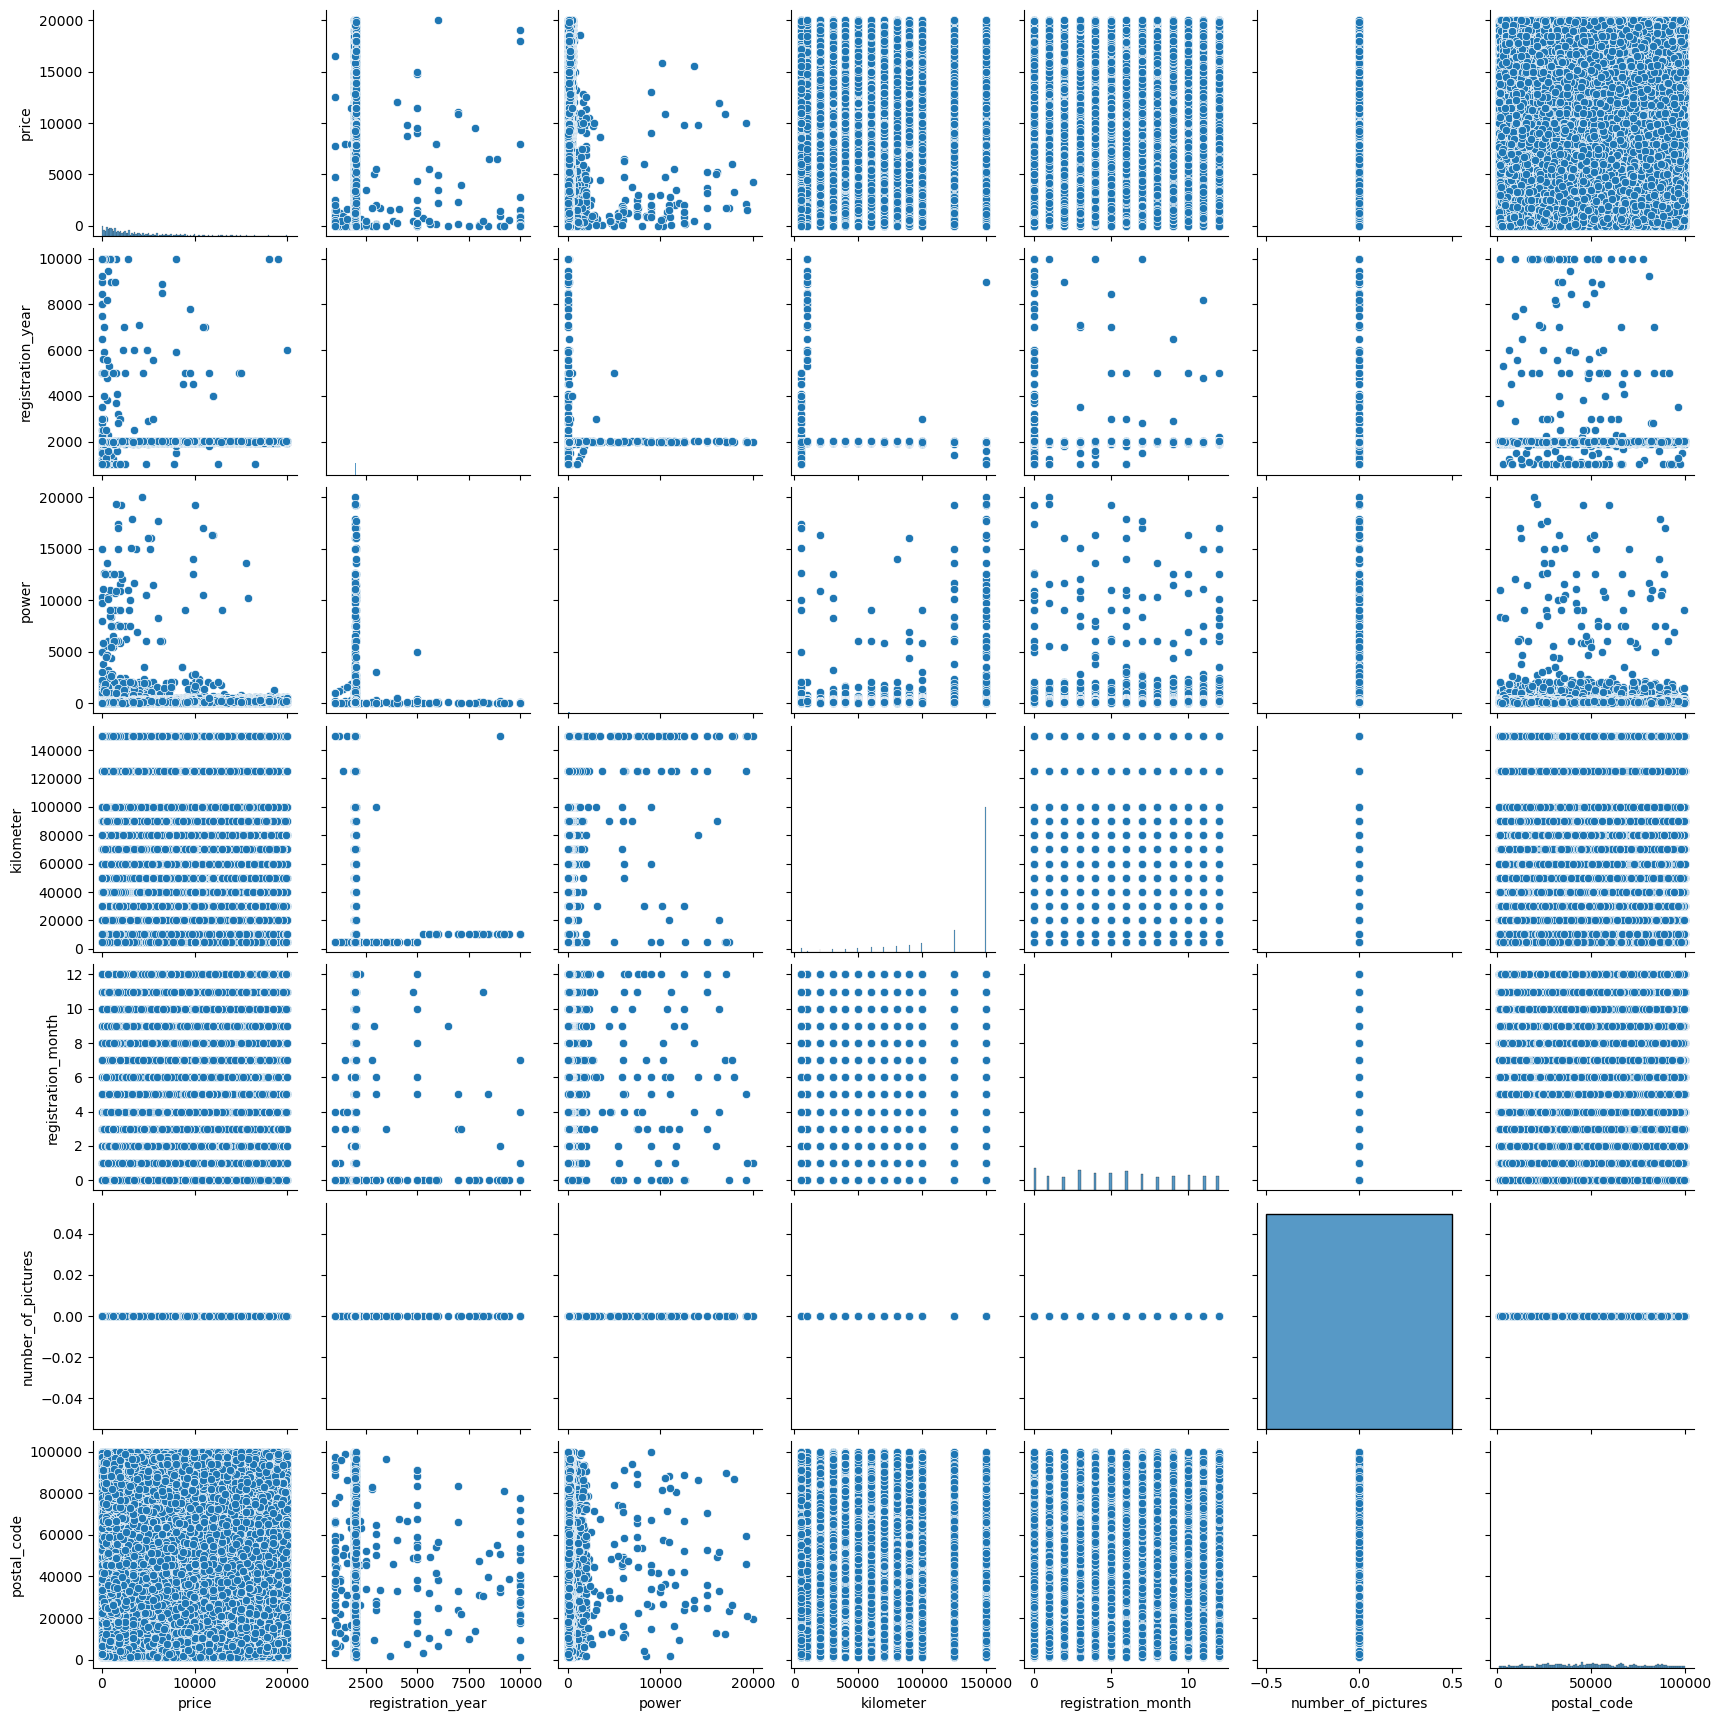

In [23]:
plt.figure(figsize=(18, 18))
sns.pairplot(data=data)
plt.show(close=None, block=None)

**Целевой признак 'price'**

In [24]:
data['price'].describe()

count    354365.000000
mean       4416.679830
std        4514.176349
min           0.000000
25%        1050.000000
50%        2700.000000
75%        6400.000000
max       20000.000000
Name: price, dtype: float64

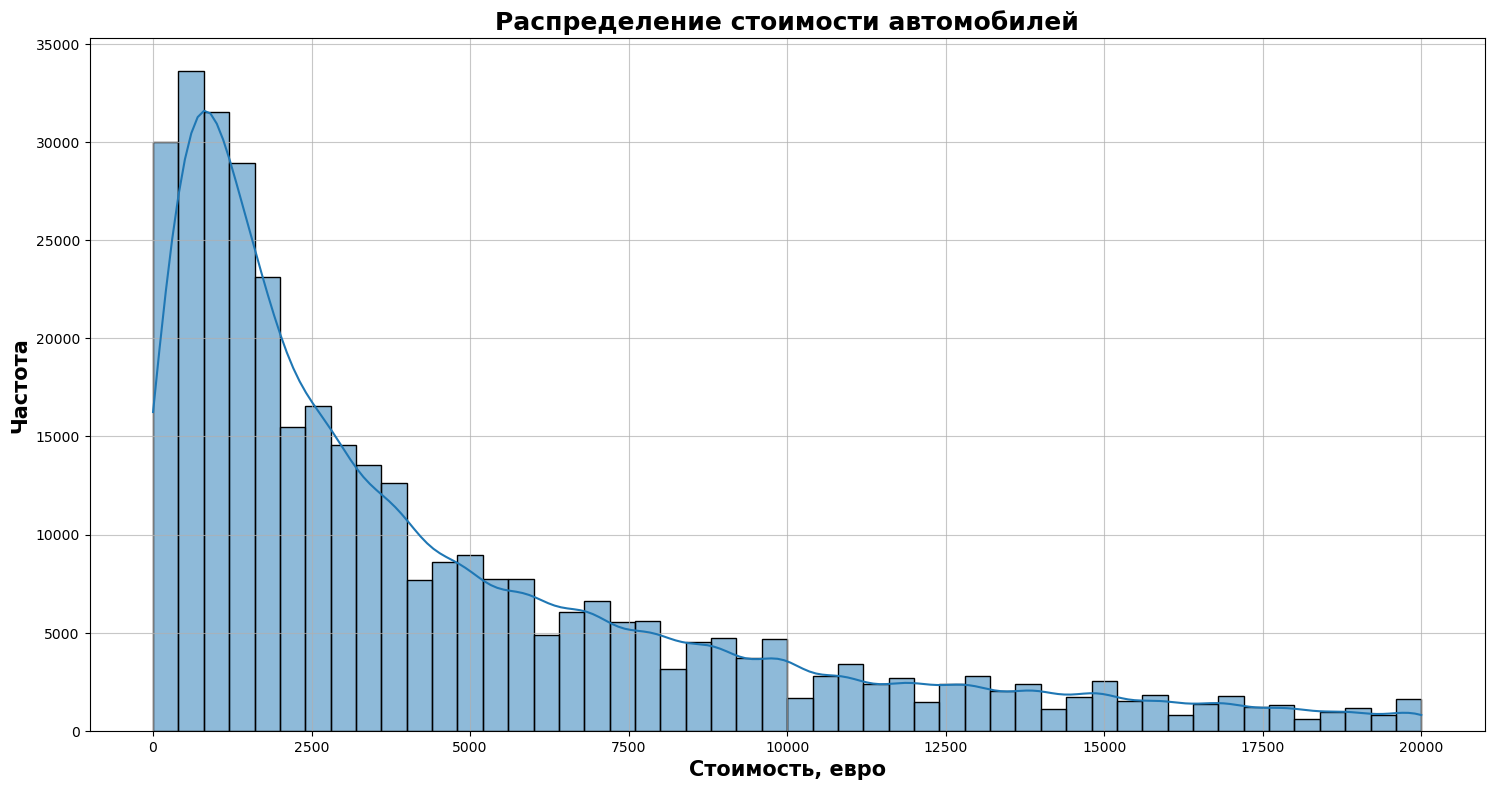

In [25]:
fig, ax = plt.subplots(figsize=(18, 9))
sns.histplot(data=data, x='price', bins=50, kde=True)
ax.set_title('Распределение стоимости автомобилей', fontsize=18, fontweight='bold')
ax.set_xlabel('Стоимость, евро', fontsize=15, fontweight='bold')
ax.set_ylabel('Частота', fontsize=15, fontweight='bold')
ax.grid(True, alpha=0.7)
plt.show(close=None, block=None)

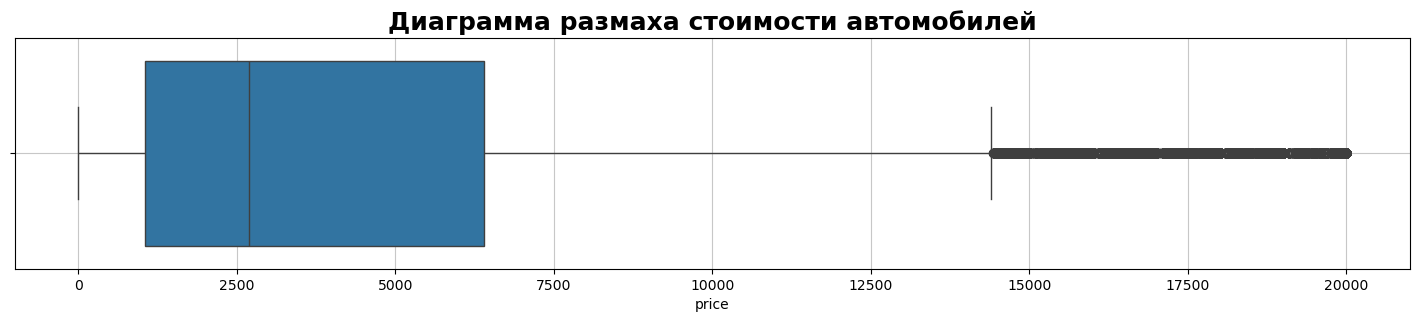

In [26]:
fig, ax = plt.subplots(figsize=(18, 3))
sns.boxplot(data=data, x='price', orient='h')
ax.set_title('Диаграмма размаха стоимости автомобилей', fontsize=18, fontweight='bold')
ax.grid(True, alpha=0.7)
plt.show(close=None, block=None)

В целевом признаке имеются нулевые значения стоимости, а также на диаграмме размаха видно, что показатель имеет выбросы. Удалим строки с нулевым значением стоимости и сделаем срез набора данных поквантилям в интервале от 0.05 до 0.95.

Количество меток в наборе данных с нулевой стоимостью авто

In [27]:
data.query('price == 0').shape

(10772, 16)

In [28]:
data = data.query('price != 0')
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 343593 entries, 0 to 354364
Data columns (total 16 columns):
 #   Column              Non-Null Count   Dtype         
---  ------              --------------   -----         
 0   date_crawled        343593 non-null  datetime64[ns]
 1   price               343593 non-null  int64         
 2   vehicle_type        343593 non-null  category      
 3   registration_year   343593 non-null  int64         
 4   gearbox             343593 non-null  category      
 5   power               343593 non-null  int64         
 6   model               343593 non-null  category      
 7   kilometer           343593 non-null  int64         
 8   registration_month  343593 non-null  int64         
 9   fuel_type           343593 non-null  category      
 10  brand               343593 non-null  category      
 11  repaired            343593 non-null  category      
 12  date_created        343593 non-null  datetime64[ns]
 13  number_of_pictures  343593 non-nul

In [29]:
data['price'].quantile([0.05, 0.95])

0.05      350.0
0.95    14800.0
Name: price, dtype: float64

In [30]:
data = data.query('350 <= price')
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 328024 entries, 0 to 354364
Data columns (total 16 columns):
 #   Column              Non-Null Count   Dtype         
---  ------              --------------   -----         
 0   date_crawled        328024 non-null  datetime64[ns]
 1   price               328024 non-null  int64         
 2   vehicle_type        328024 non-null  category      
 3   registration_year   328024 non-null  int64         
 4   gearbox             328024 non-null  category      
 5   power               328024 non-null  int64         
 6   model               328024 non-null  category      
 7   kilometer           328024 non-null  int64         
 8   registration_month  328024 non-null  int64         
 9   fuel_type           328024 non-null  category      
 10  brand               328024 non-null  category      
 11  repaired            328024 non-null  category      
 12  date_created        328024 non-null  datetime64[ns]
 13  number_of_pictures  328024 non-nul

Визуализируем распределение целевого признака после обработки

In [31]:
data['price'].describe()

count    328024.000000
mean       4762.272337
std        4517.330509
min         350.000000
25%        1350.000000
50%        3000.000000
75%        6800.000000
max       20000.000000
Name: price, dtype: float64

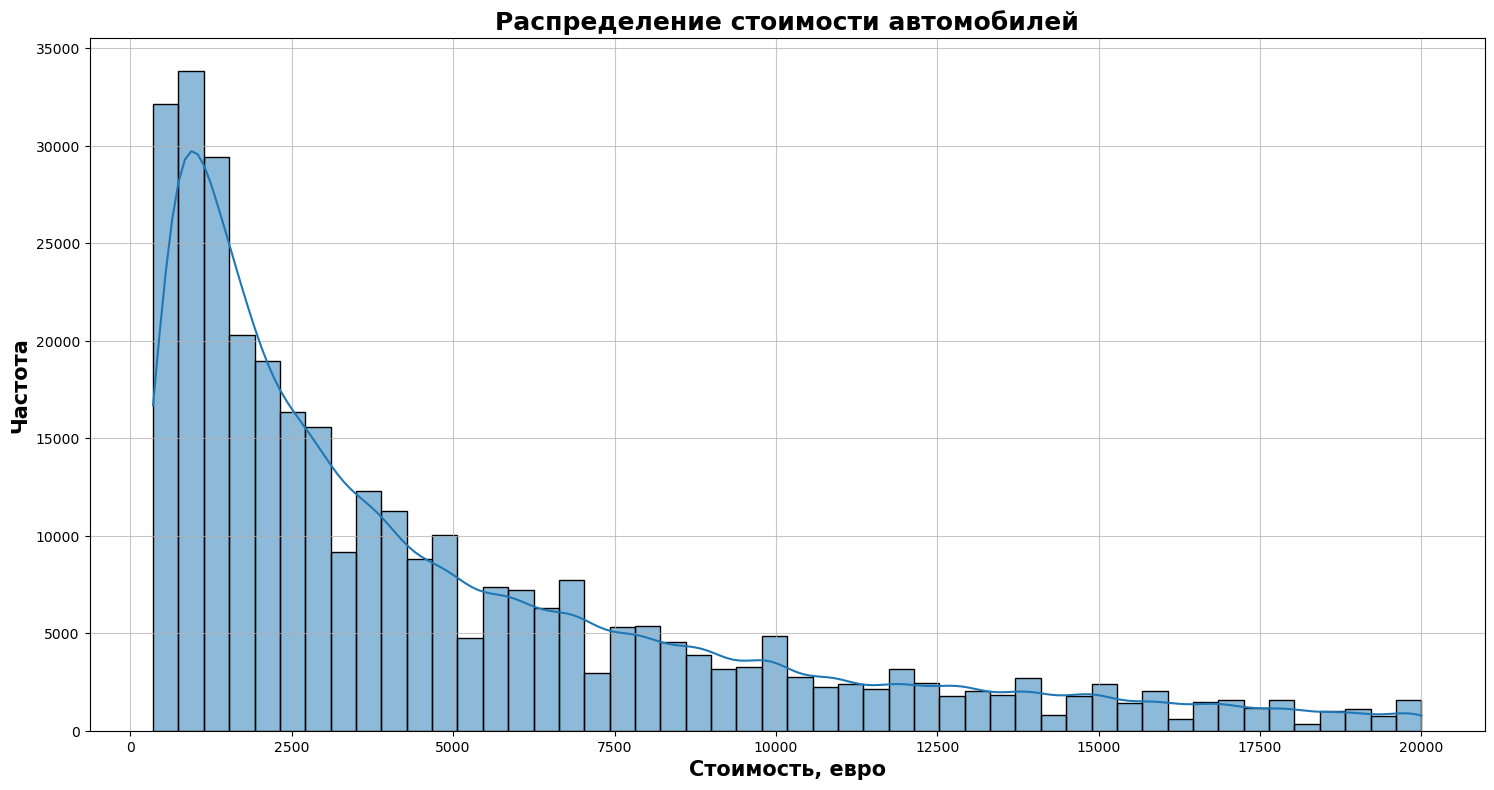

In [32]:
fig, ax = plt.subplots(figsize=(18, 9))
sns.histplot(data=data, x='price', bins=50, kde=True)
ax.set_title('Распределение стоимости автомобилей', fontsize=18, fontweight='bold')
ax.set_xlabel('Стоимость, евро', fontsize=15, fontweight='bold')
ax.set_ylabel('Частота', fontsize=15, fontweight='bold')
ax.grid(True, alpha=0.7)
plt.show(close=None, block=None)

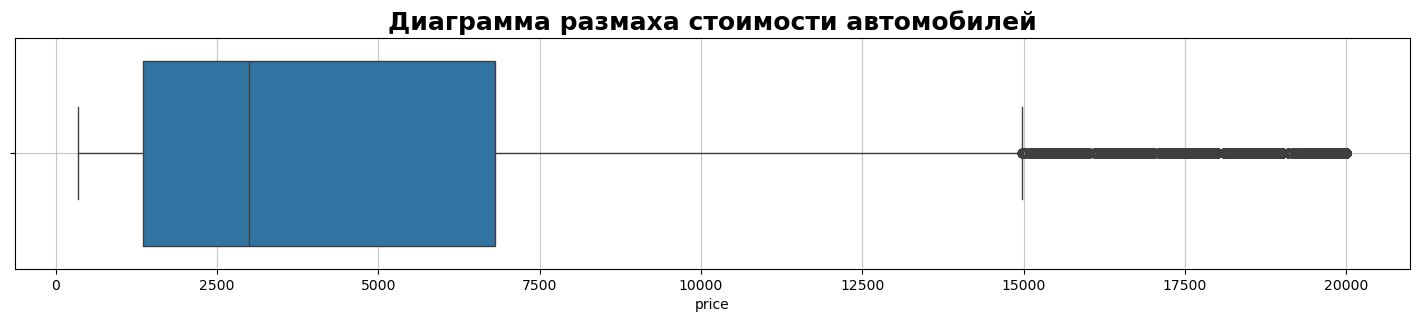

In [33]:
fig, ax = plt.subplots(figsize=(18, 3))
sns.boxplot(data=data, x='price', orient='h')
ax.set_title('Диаграмма размаха стоимости автомобилей', fontsize=18, fontweight='bold')
ax.grid(True, alpha=0.7)
plt.show(close=None, block=None)

Автомобили с нулевой стоимостью отсутствуют и количество выбросов заметно уменьшилось.

**Количественные и категориальные входные признаки**

Тип автомобильного кузова ('vehicle_type')

In [34]:
data['vehicle_type'].value_counts()

vehicle_type
sedan          87167
small          71997
wagon          62104
unknown        29199
bus            28066
convertible    19694
coupe          15172
suv            11737
other           2888
Name: count, dtype: int64

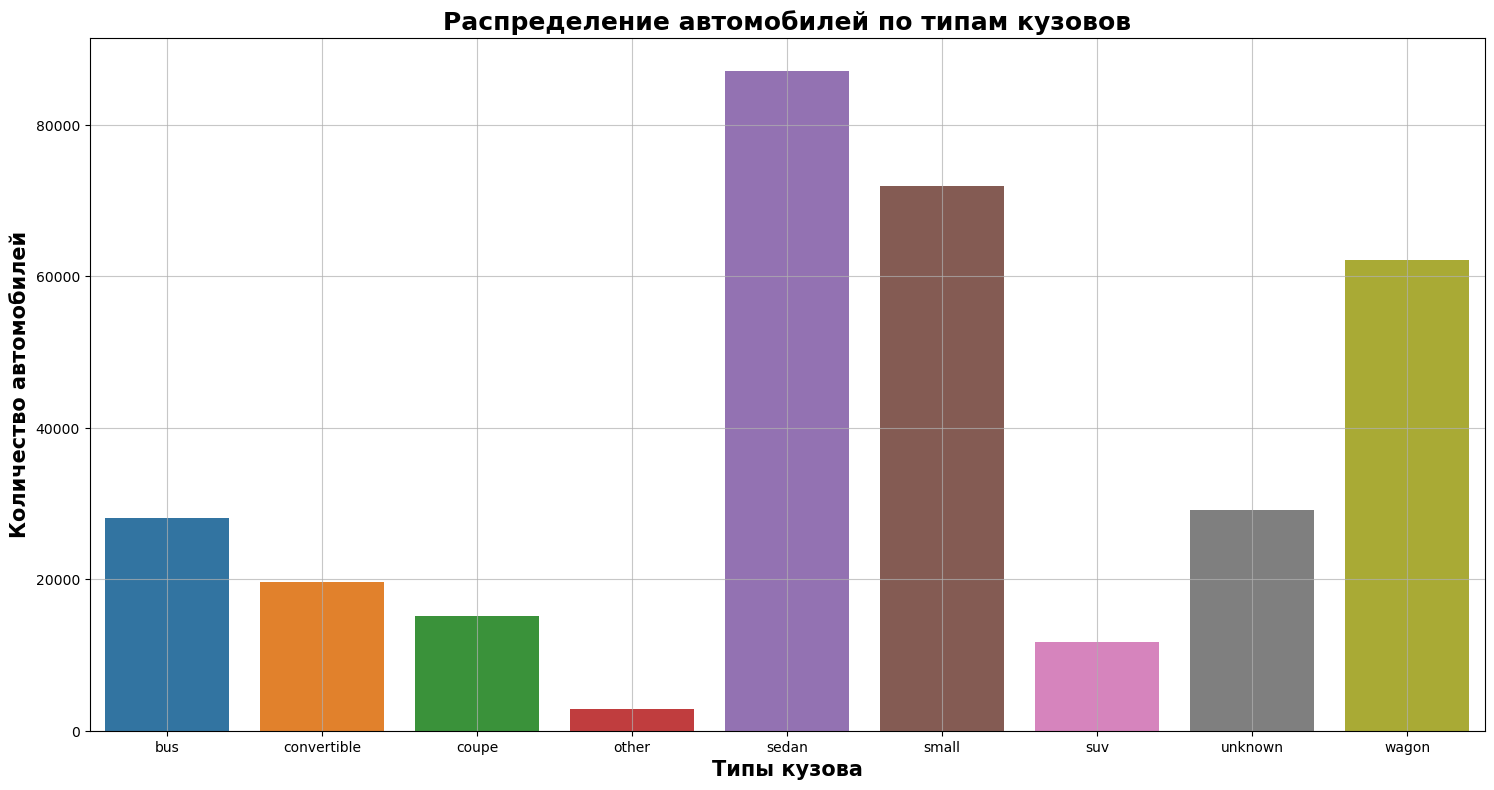

In [35]:
fig, ax = plt.subplots(figsize=(18, 9))
ax = sns.countplot(x='vehicle_type', data=data, palette='tab10')
ax.set_title('Распределение автомобилей по типам кузовов', fontsize=18, fontweight='bold')
ax.set_xlabel('Типы кузова', fontsize=15, fontweight='bold')
ax.set_ylabel('Количество автомобилей', fontsize=15, fontweight='bold')
ax.tick_params(axis='x', rotation=0)
ax.grid(True, alpha=0.7)
plt.show(close=None, block=None)

Год регистрации ('registration_year')

In [36]:
data['registration_year'].value_counts().sort_values()

registration_year
1946        1
7800        1
1602        1
1039        1
1111        1
        ...  
2003    19373
2006    19632
1999    20668
2000    20959
2005    21178
Name: count, Length: 133, dtype: int64

In [37]:
data['registration_year'].sort_values().unique()

array([1000, 1001, 1039, 1111, 1234, 1300, 1400, 1500, 1600, 1602, 1800,
       1910, 1923, 1925, 1927, 1928, 1929, 1930, 1931, 1932, 1933, 1934,
       1935, 1936, 1937, 1938, 1940, 1941, 1942, 1943, 1944, 1945, 1946,
       1947, 1948, 1949, 1950, 1951, 1952, 1953, 1954, 1955, 1956, 1957,
       1958, 1959, 1960, 1961, 1962, 1963, 1964, 1965, 1966, 1967, 1968,
       1969, 1970, 1971, 1972, 1973, 1974, 1975, 1976, 1977, 1978, 1979,
       1980, 1981, 1982, 1983, 1984, 1985, 1986, 1987, 1988, 1989, 1990,
       1991, 1992, 1993, 1994, 1995, 1996, 1997, 1998, 1999, 2000, 2001,
       2002, 2003, 2004, 2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012,
       2013, 2014, 2015, 2016, 2017, 2018, 2019, 2066, 2290, 2500, 2800,
       2900, 3000, 3200, 3700, 3800, 4000, 4100, 4500, 4800, 5000, 5300,
       5555, 5911, 6000, 7000, 7100, 7800, 8200, 8500, 8888, 9000, 9450,
       9999], dtype=int64)

В столбце имеются аномальные значения годов. Сделаем срез с записью в набор данных и оставим только реальные годы, а также исключим очень старые автомобили до 1960 года. 

In [38]:
data = data.query('1960 <= registration_year <= 2019')
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 327688 entries, 0 to 354364
Data columns (total 16 columns):
 #   Column              Non-Null Count   Dtype         
---  ------              --------------   -----         
 0   date_crawled        327688 non-null  datetime64[ns]
 1   price               327688 non-null  int64         
 2   vehicle_type        327688 non-null  category      
 3   registration_year   327688 non-null  int64         
 4   gearbox             327688 non-null  category      
 5   power               327688 non-null  int64         
 6   model               327688 non-null  category      
 7   kilometer           327688 non-null  int64         
 8   registration_month  327688 non-null  int64         
 9   fuel_type           327688 non-null  category      
 10  brand               327688 non-null  category      
 11  repaired            327688 non-null  category      
 12  date_created        327688 non-null  datetime64[ns]
 13  number_of_pictures  327688 non-nul

In [39]:
data['registration_year'].sort_values().unique()

array([1960, 1961, 1962, 1963, 1964, 1965, 1966, 1967, 1968, 1969, 1970,
       1971, 1972, 1973, 1974, 1975, 1976, 1977, 1978, 1979, 1980, 1981,
       1982, 1983, 1984, 1985, 1986, 1987, 1988, 1989, 1990, 1991, 1992,
       1993, 1994, 1995, 1996, 1997, 1998, 1999, 2000, 2001, 2002, 2003,
       2004, 2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014,
       2015, 2016, 2017, 2018, 2019], dtype=int64)

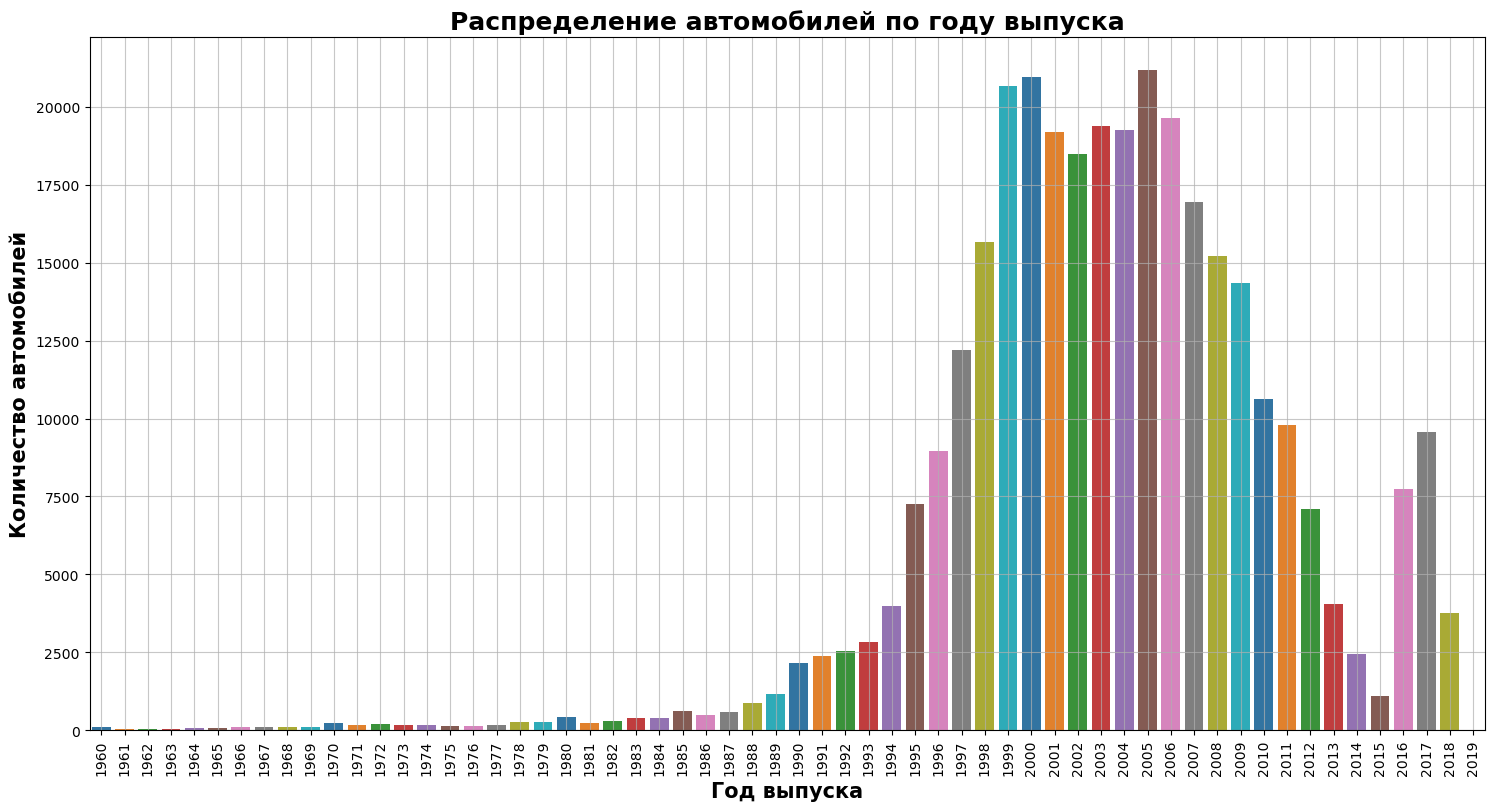

In [40]:
fig, ax = plt.subplots(figsize=(18, 9))
ax = sns.countplot(x='registration_year', data=data, palette='tab10')
ax.set_title('Распределение автомобилей по году выпуска', fontsize=18, fontweight='bold')
ax.set_xlabel('Год выпуска', fontsize=15, fontweight='bold')
ax.set_ylabel('Количество автомобилей', fontsize=15, fontweight='bold')
ax.tick_params(axis='x', rotation=90)
ax.grid(True, alpha=0.7)
plt.show(close=None, block=None)

Тип коробки передач ('gearbox')

In [41]:
data['gearbox'].value_counts()

gearbox
manual     249437
auto        63998
unknown     14253
Name: count, dtype: int64

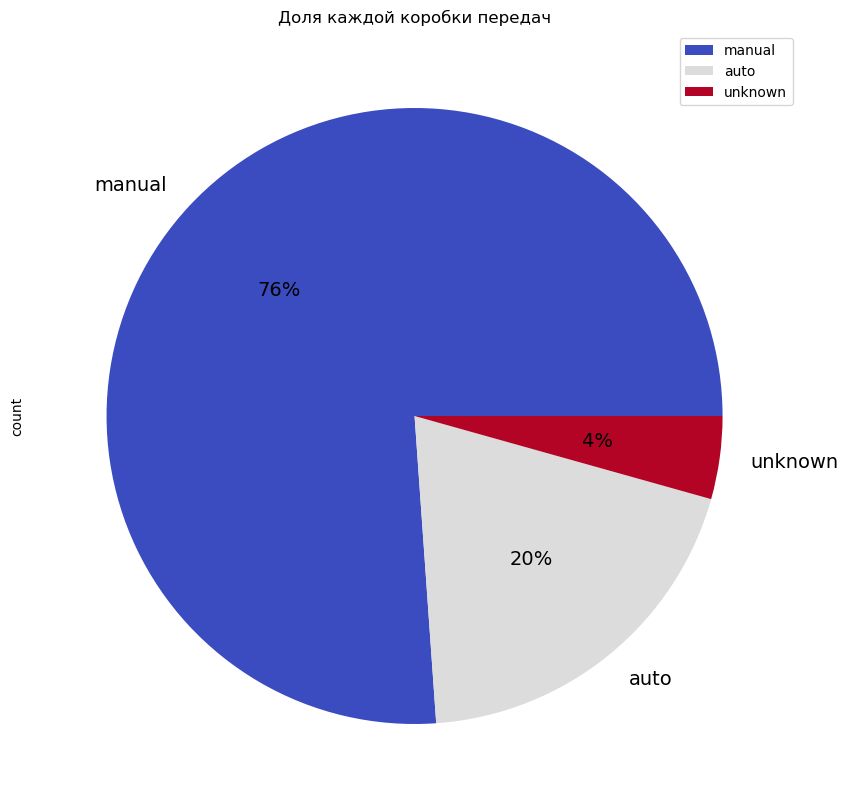

In [42]:
data['gearbox'].value_counts().plot(
    kind='pie', 
    figsize=(10, 10), 
    title='Доля каждой коробки передач', 
    autopct='%1.0f%%', 
    legend=True, 
    cmap='coolwarm', 
    fontsize=14)
plt.show(close=None, block=None)

Мощность двигателя ('power')

In [43]:
data['power'].value_counts()

power
0       30948
75      21846
150     13999
60      13756
101     12677
        ...  
2461        1
6006        1
6018        1
612         1
1548        1
Name: count, Length: 679, dtype: int64

In [44]:
data['power'].sort_values().unique()

array([    0,     1,     2,     3,     4,     5,     6,     7,     8,
           9,    10,    11,    12,    13,    14,    15,    16,    17,
          18,    19,    20,    21,    22,    23,    24,    25,    26,
          27,    28,    29,    30,    31,    33,    34,    35,    36,
          37,    38,    39,    40,    41,    42,    43,    44,    45,
          46,    47,    48,    49,    50,    51,    52,    53,    54,
          55,    56,    57,    58,    59,    60,    61,    62,    63,
          64,    65,    66,    67,    68,    69,    70,    71,    72,
          73,    74,    75,    76,    77,    78,    79,    80,    81,
          82,    83,    84,    85,    86,    87,    88,    89,    90,
          91,    92,    93,    94,    95,    96,    97,    98,    99,
         100,   101,   102,   103,   104,   105,   106,   107,   108,
         109,   110,   111,   112,   113,   114,   115,   116,   117,
         118,   119,   120,   121,   122,   123,   124,   125,   126,
         127,   128,

В столбце имеются аномальные мощности двигателей автомобилей. Сделаем срез с записью в набор данных и оставим только автомобили с мощностью двигателя в интервале от 50 до 400 лошадиных сил. 

In [45]:
data = data.query('50 <= power <= 400')
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 291504 entries, 1 to 354364
Data columns (total 16 columns):
 #   Column              Non-Null Count   Dtype         
---  ------              --------------   -----         
 0   date_crawled        291504 non-null  datetime64[ns]
 1   price               291504 non-null  int64         
 2   vehicle_type        291504 non-null  category      
 3   registration_year   291504 non-null  int64         
 4   gearbox             291504 non-null  category      
 5   power               291504 non-null  int64         
 6   model               291504 non-null  category      
 7   kilometer           291504 non-null  int64         
 8   registration_month  291504 non-null  int64         
 9   fuel_type           291504 non-null  category      
 10  brand               291504 non-null  category      
 11  repaired            291504 non-null  category      
 12  date_created        291504 non-null  datetime64[ns]
 13  number_of_pictures  291504 non-nul

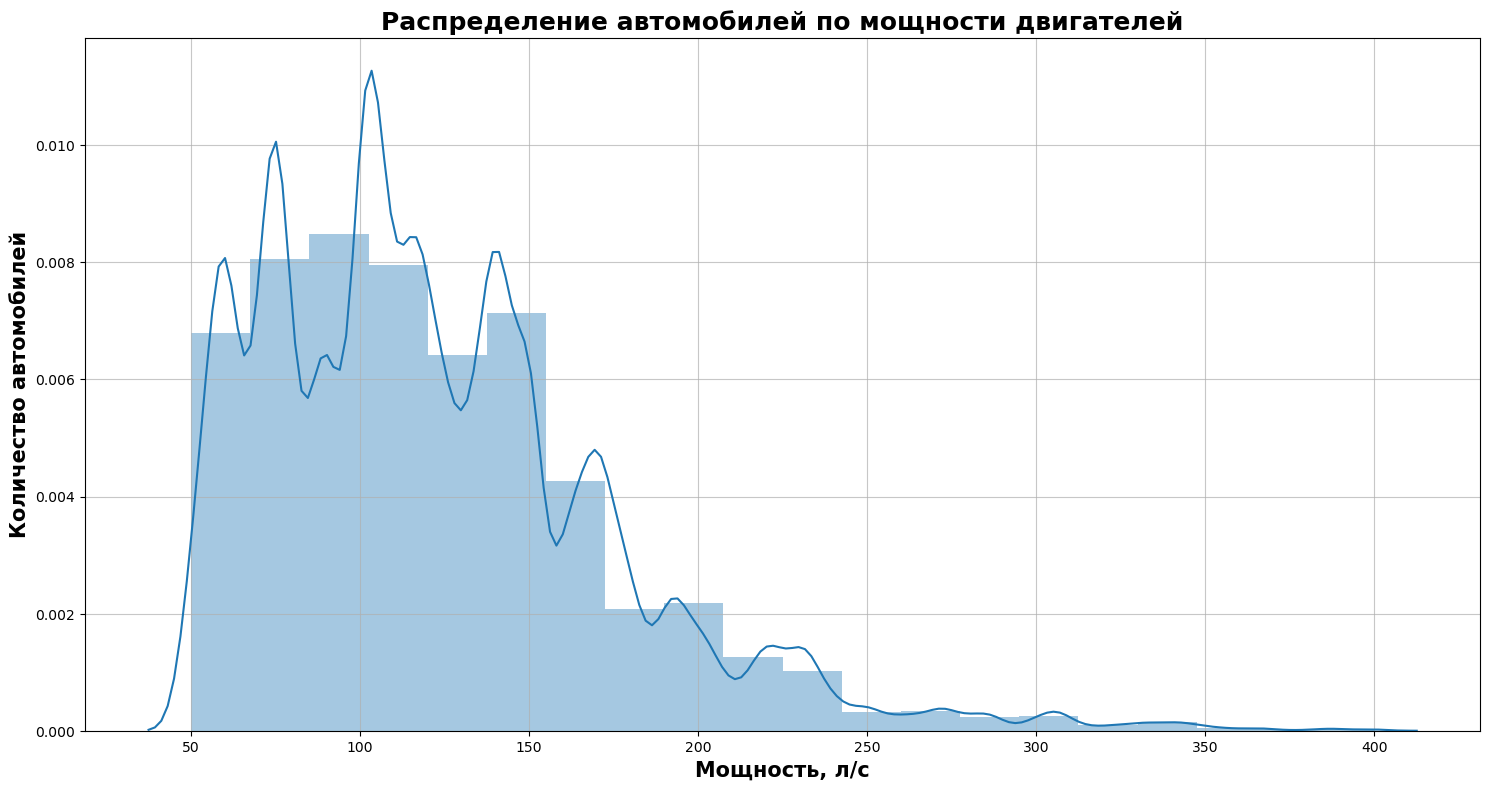

In [46]:
fig, ax = plt.subplots(figsize=(18, 9))
sns.distplot(data['power'], bins=20, kde=True)
ax.set_title('Распределение автомобилей по мощности двигателей', fontsize=18, fontweight='bold')
ax.set_xlabel('Мощность, л/с', fontsize=15, fontweight='bold')
ax.set_ylabel('Количество автомобилей', fontsize=15, fontweight='bold')
ax.grid(True, alpha=0.7)
plt.show(close=None, block=None)

Модель автомобиля ('model')

In [47]:
data['model'].value_counts()

model
golf                  25052
other                 19489
3er                   17491
unknown               10985
polo                   9554
                      ...  
serie_3                   3
rangerover                3
range_rover_evoque        2
601                       1
serie_1                   0
Name: count, Length: 251, dtype: int64

In [48]:
data['model'].sort_values().unique()

['100', '145', '147', '156', '159', ..., 'yaris', 'yeti', 'ypsilon', 'z_reihe', 'zafira']
Length: 250
Categories (251, object): ['100', '145', '147', '156', ..., 'yeti', 'ypsilon', 'z_reihe', 'zafira']

В столбе 'model' имеются модели автомобилей с нулевым и низким количеством по 1 или 2 машины и т.д. Удалим автомобили с количеством менее 10, так как при построении моделей машинного обучения и предсказаний может появиться ошибка, если все эти модели попадут в тестовую выборку, а в тренировочной их не окажется.

In [49]:
value_counts = data['model'].value_counts()
to_remove = value_counts[value_counts <= 10].index
data = data[~data.model.isin(to_remove)]

In [50]:
data['model'].value_counts()

model
golf          25052
other         19489
3er           17491
unknown       10985
polo           9554
              ...  
601               0
elefantino        0
rangerover        0
kalina            0
serie_2           0
Name: count, Length: 251, dtype: int64

Пробег автомобиля ('kilometer')

In [51]:
data['kilometer'].value_counts()

kilometer
150000    193211
125000     31518
100000     12617
90000      10203
80000       8995
70000       7744
60000       6769
50000       5616
40000       4449
30000       3797
20000       3155
5000        2545
10000        851
Name: count, dtype: int64

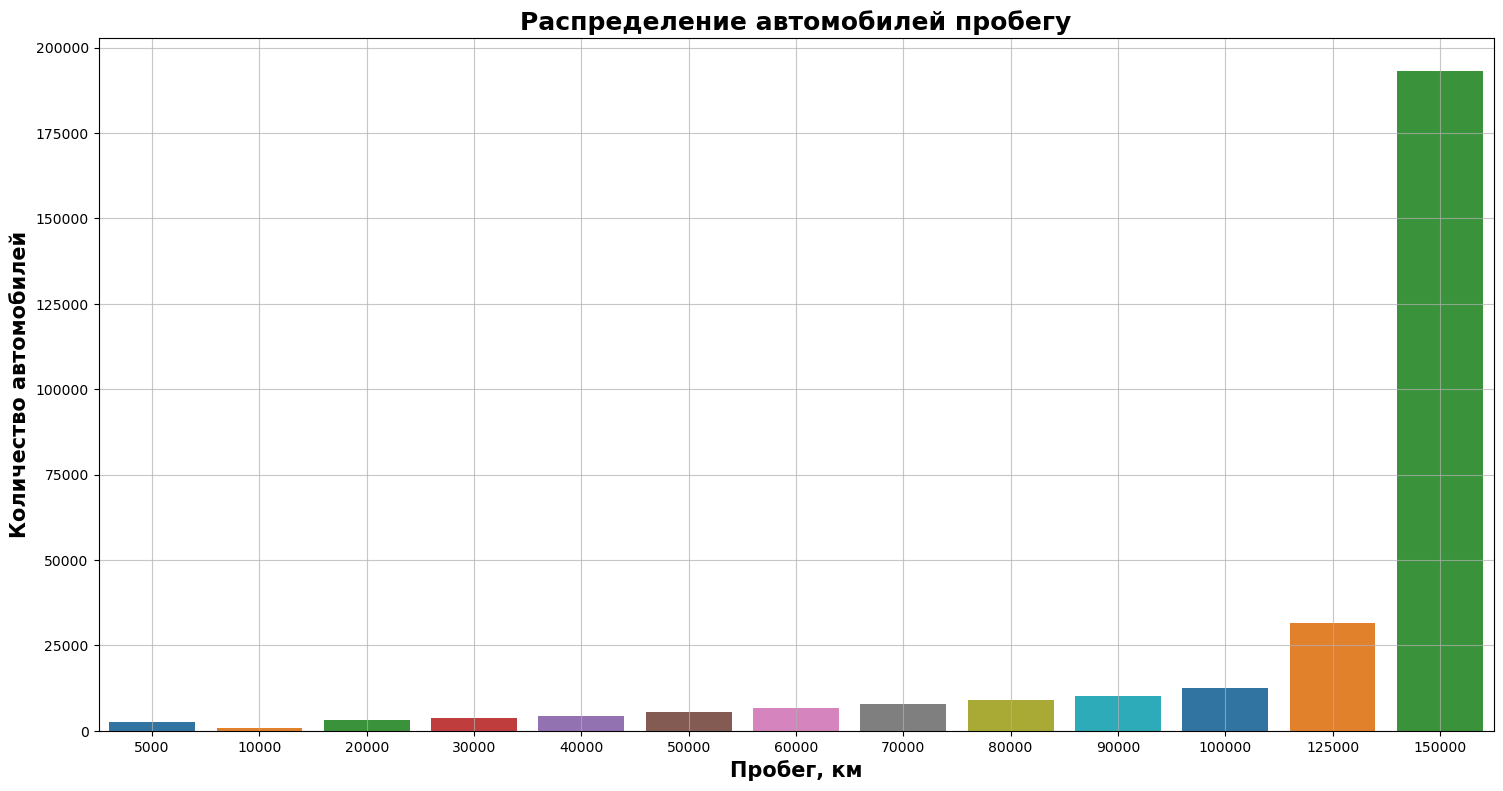

In [52]:
fig, ax = plt.subplots(figsize=(18, 9))
ax =sns.countplot(x='kilometer', data=data, palette='tab10')
ax.set_title('Распределение автомобилей пробегу', fontsize=18, fontweight='bold')
ax.set_xlabel('Пробег, км', fontsize=15, fontweight='bold')
ax.set_ylabel('Количество автомобилей', fontsize=15, fontweight='bold')
ax.tick_params(axis='x', rotation=0)
ax.grid(True, alpha=0.7)
plt.show(close=None, block=None)

Месяц регистрации автомобиля ('registration_month')

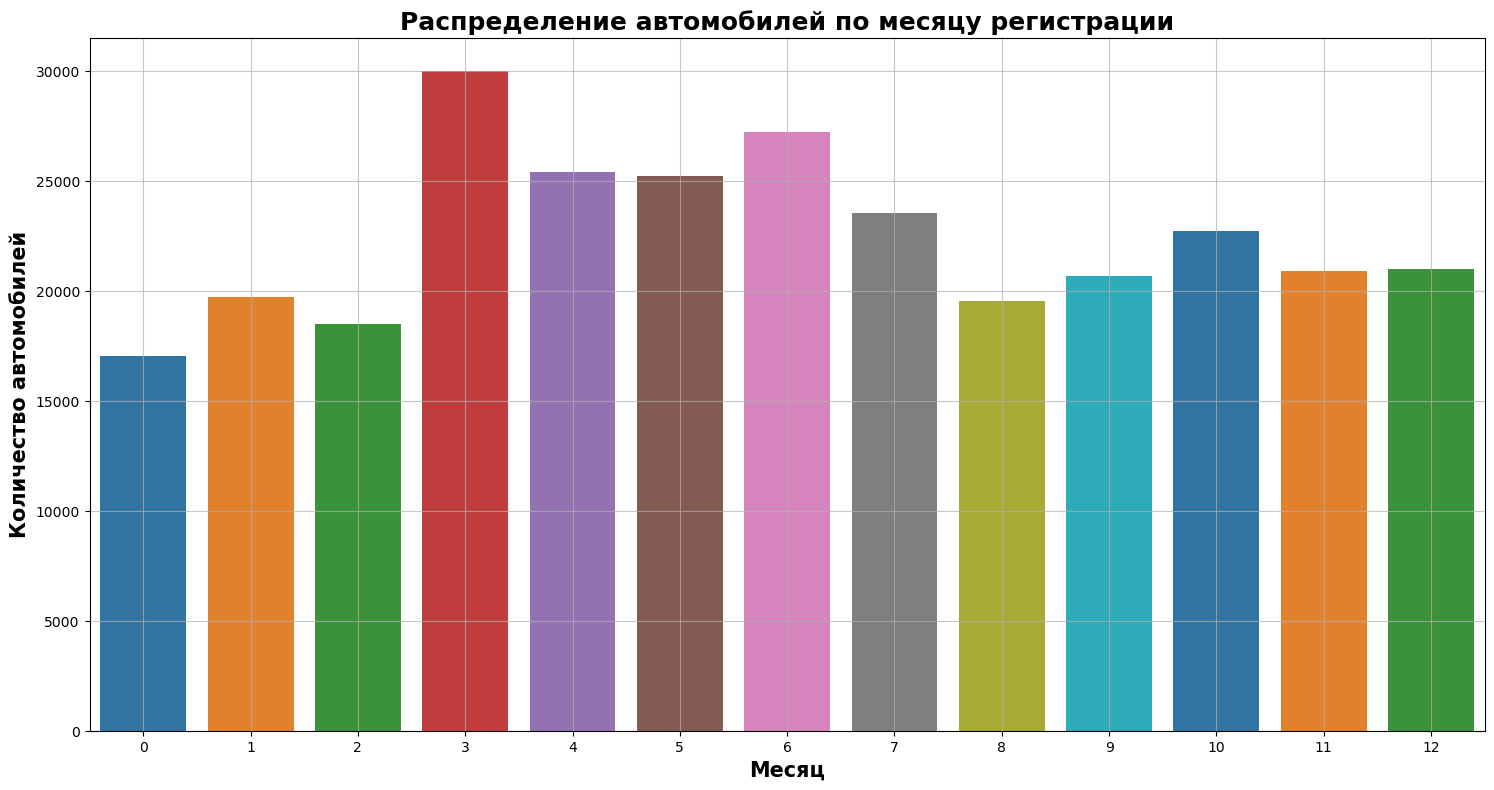

In [53]:
fig, ax = plt.subplots(figsize=(18, 9))
ax =sns.countplot(x='registration_month', data=data, palette='tab10')
ax.set_title('Распределение автомобилей по месяцу регистрации', fontsize=18, fontweight='bold')
ax.set_xlabel('Месяц', fontsize=15, fontweight='bold')
ax.set_ylabel('Количество автомобилей', fontsize=15, fontweight='bold')
ax.tick_params(axis='x', rotation=0)
ax.grid(True, alpha=0.7)
plt.show(close=None, block=None)

Тип топлива ('fuel_type')

In [54]:
data['fuel_type'].value_counts()

fuel_type
petrol      268663
unknown      17322
lpg           4710
cng            487
hybrid         203
other           53
electric        32
Name: count, dtype: int64

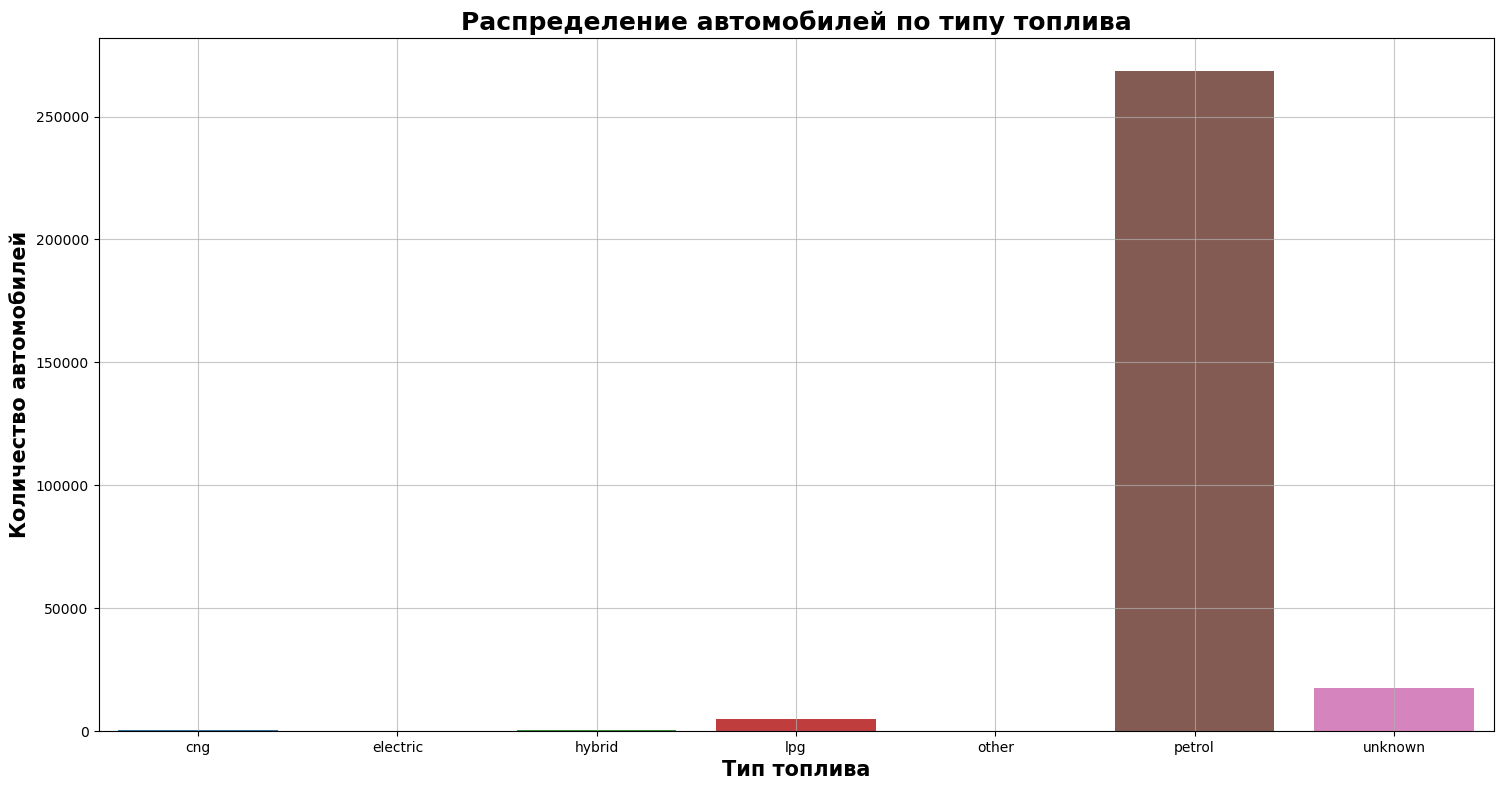

In [55]:
fig, ax = plt.subplots(figsize=(18, 9))
ax = sns.countplot(x='fuel_type', data=data, palette='tab10')
ax.set_title('Распределение автомобилей по типу топлива', fontsize=18, fontweight='bold')
ax.set_xlabel('Тип топлива', fontsize=15, fontweight='bold')
ax.set_ylabel('Количество автомобилей', fontsize=15, fontweight='bold')
ax.tick_params(axis='x', rotation=0)
ax.grid(True, alpha=0.7)
plt.show(close=None, block=None)

Марка автомобиля ('brand')


In [56]:
data['brand'].value_counts().sort_index()

brand
alfa_romeo         1971
audi              25951
bmw               32621
chevrolet          1480
chrysler           1156
citroen            4137
dacia               821
daewoo              376
daihatsu            521
fiat               7139
ford              19804
honda              2411
hyundai            3133
jaguar              435
jeep                581
kia                2123
lada                148
lancia              353
land_rover          458
mazda              4713
mercedes_benz     27814
mini               3026
mitsubishi         2424
nissan             3924
opel              30769
peugeot            9169
porsche             582
renault           13521
rover               342
saab                466
seat               5847
skoda              4997
smart              3713
sonstige_autos     1546
subaru              613
suzuki             1887
toyota             4092
trabant               6
volkswagen        63605
volvo              2795
Name: count, dtype: int64

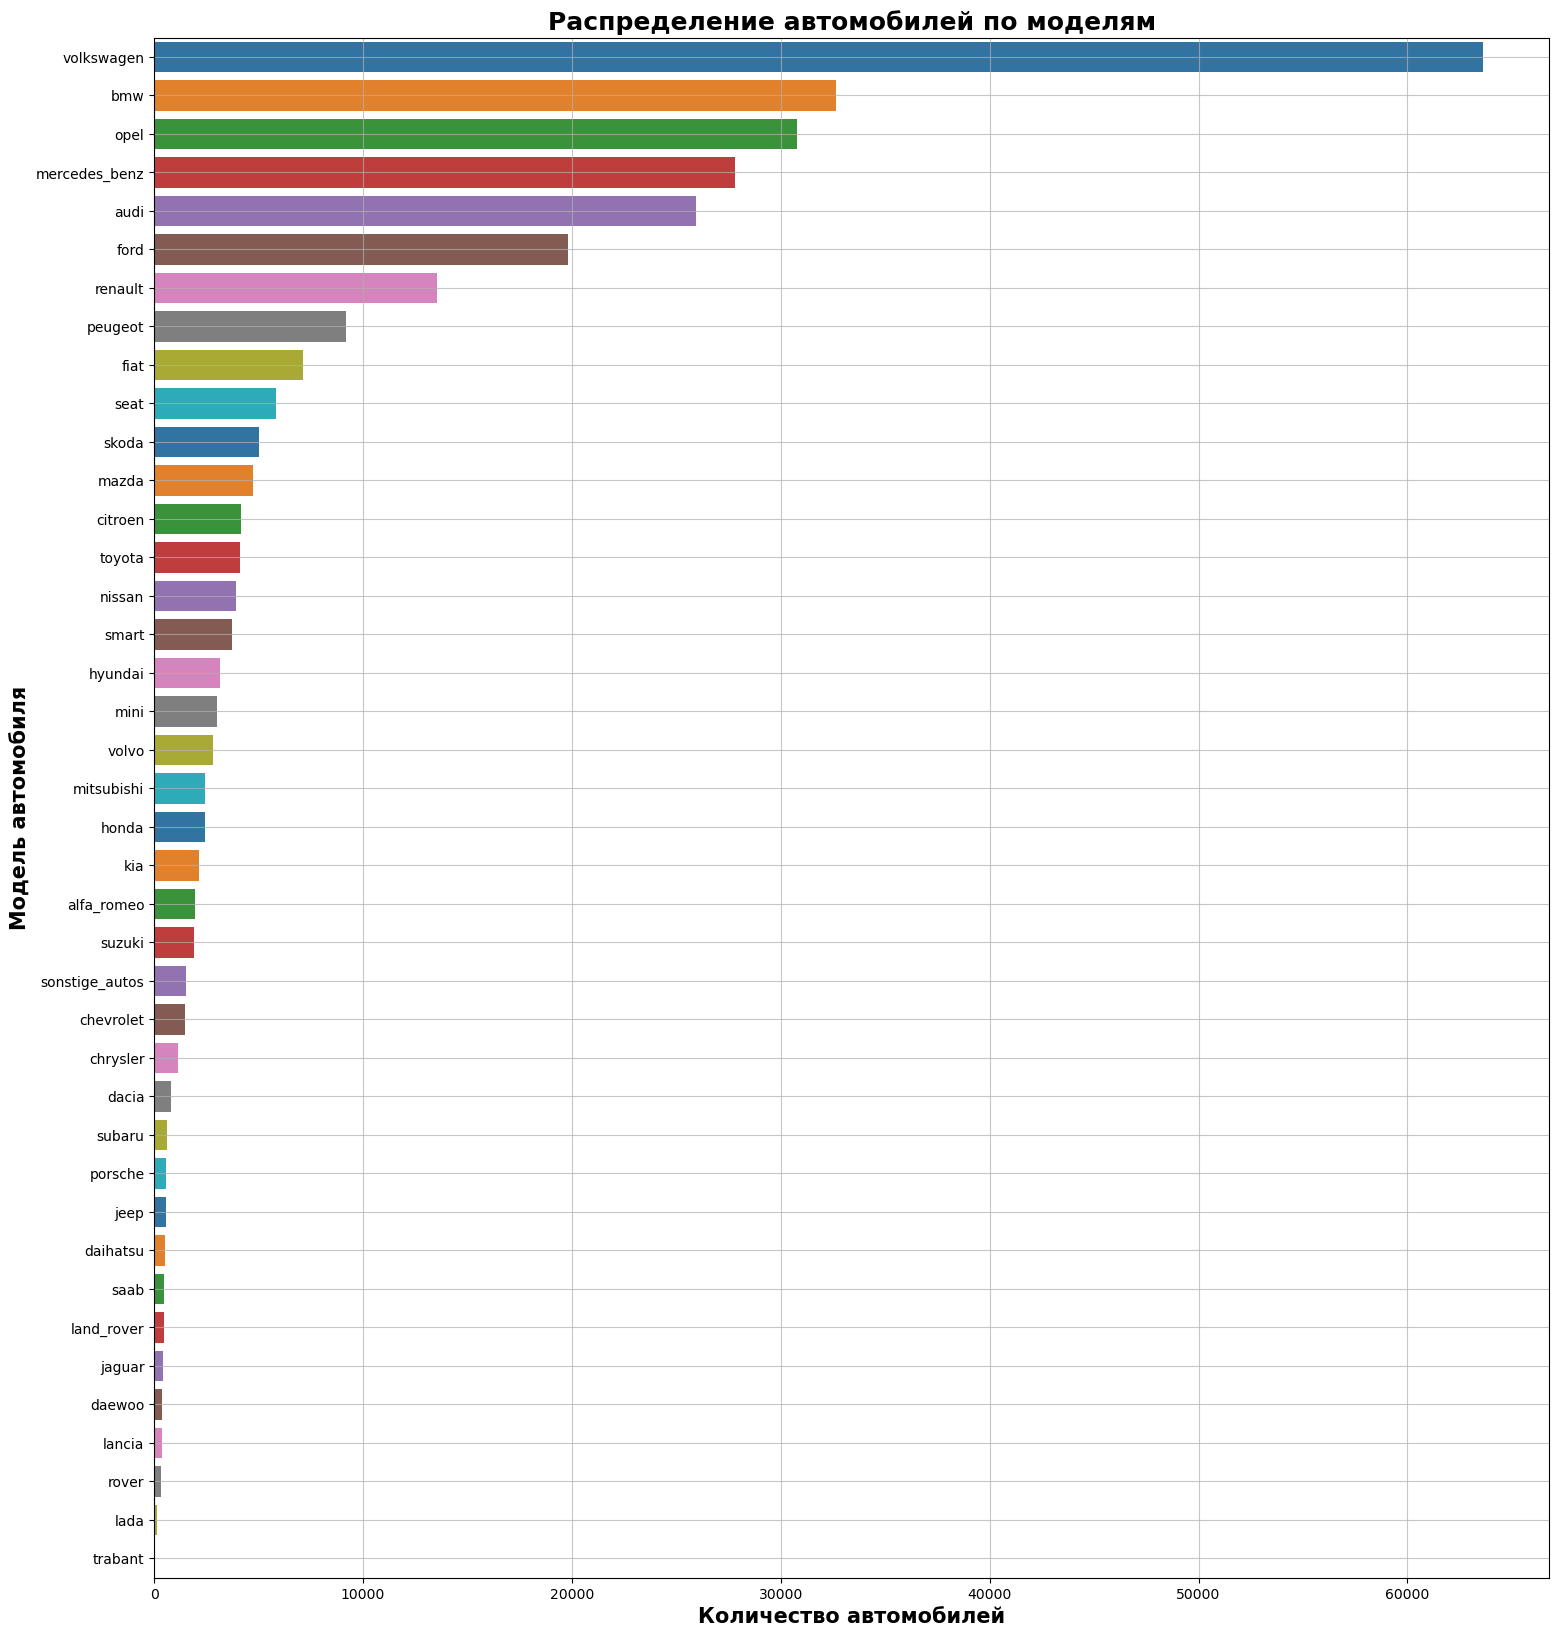

In [57]:
s = data['brand'].value_counts(ascending=False)

fig, ax = plt.subplots(figsize=(18, 20))
ax = sns.countplot(y='brand', data=data, palette='tab10', order=s.index)
ax.set_title('Распределение автомобилей по моделям', fontsize=18, fontweight='bold')
ax.set_xlabel('Количество автомобилей', fontsize=15, fontweight='bold')
ax.set_ylabel('Модель автомобиля', fontsize=15, fontweight='bold')
ax.tick_params(axis='x', rotation=0)
ax.grid(True, alpha=0.7)
plt.show(close=None, block=None)

Была машина в ремонте или нет ('repaired')

In [58]:
data['repaired'].value_counts()

repaired
no         223909
unknown     42165
yes         25396
Name: count, dtype: int64

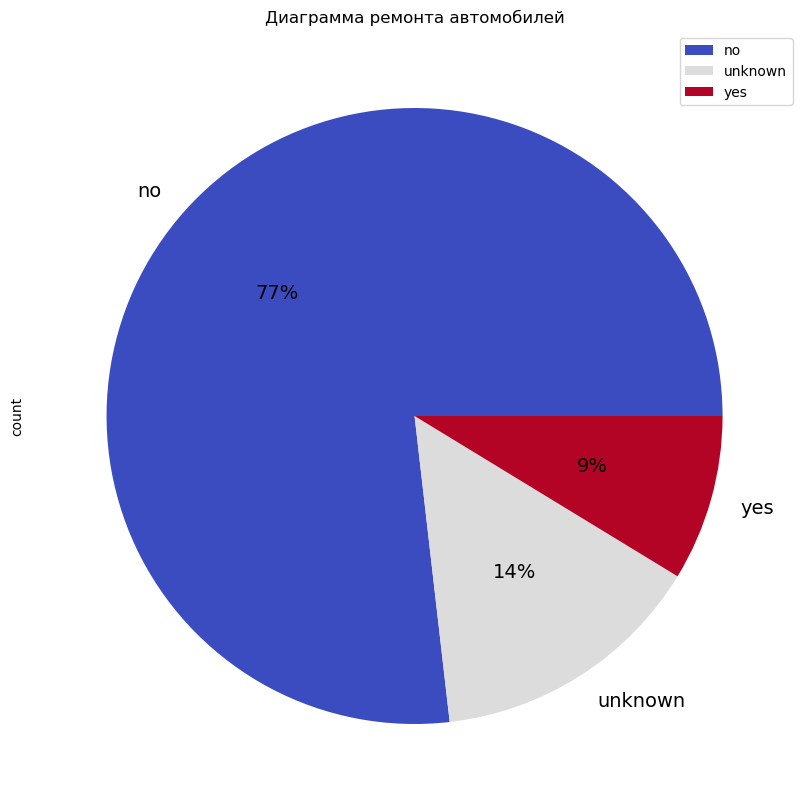

In [59]:
data['repaired'].value_counts().plot(
    kind='pie', 
    figsize=(10, 10), 
    title='Диаграмма ремонта автомобилей', 
    autopct='%1.0f%%', 
    legend=True, 
    cmap='coolwarm', 
    fontsize=14)
plt.show(close=None, block=None)

Дата создания анкеты ('date_created')

In [60]:
data['date_created'].value_counts()

date_created
2016-04-03    11540
2016-04-04    11075
2016-03-12    10774
2016-03-20    10664
2016-03-28    10398
              ...  
2016-01-15        1
2015-12-27        1
2016-01-08        1
2016-01-18        1
2015-09-09        1
Name: count, Length: 106, dtype: int64

Количество фотографий автомобиля ('number_of_pictures')

In [61]:
data['number_of_pictures'].value_counts()

number_of_pictures
0    291470
Name: count, dtype: int64

По итогам проведения исследовательского анализа удалим признаки 'postal_code' и 'number_of_pictures', которые не будем использовать при построении моделей машинного обучения. Признак 'number_of_pictures' (количество фотографий) имеет все нулевые значения, а признаки 'postal_code' (почтовый код) не связан с автомобилем и активностью пользователей и не несет полезной информации.

In [62]:
data = data.drop(['postal_code', 'number_of_pictures', 'date_crawled', 
                  'date_created', 'last_seen', 'registration_month'], axis=1)
data.head()

,price,vehicle_type,registration_year,gearbox,power,model,kilometer,fuel_type,brand,repaired
1,18300,coupe,2011,manual,190,unknown,125000,petrol,audi,yes
2,9800,suv,2004,auto,163,grand,125000,petrol,jeep,unknown
3,1500,small,2001,manual,75,golf,150000,petrol,volkswagen,no
4,3600,small,2008,manual,69,fabia,90000,petrol,skoda,no
5,650,sedan,1995,manual,102,3er,150000,petrol,bmw,yes


### Корреляционный анализ

In [63]:
data_corr = data

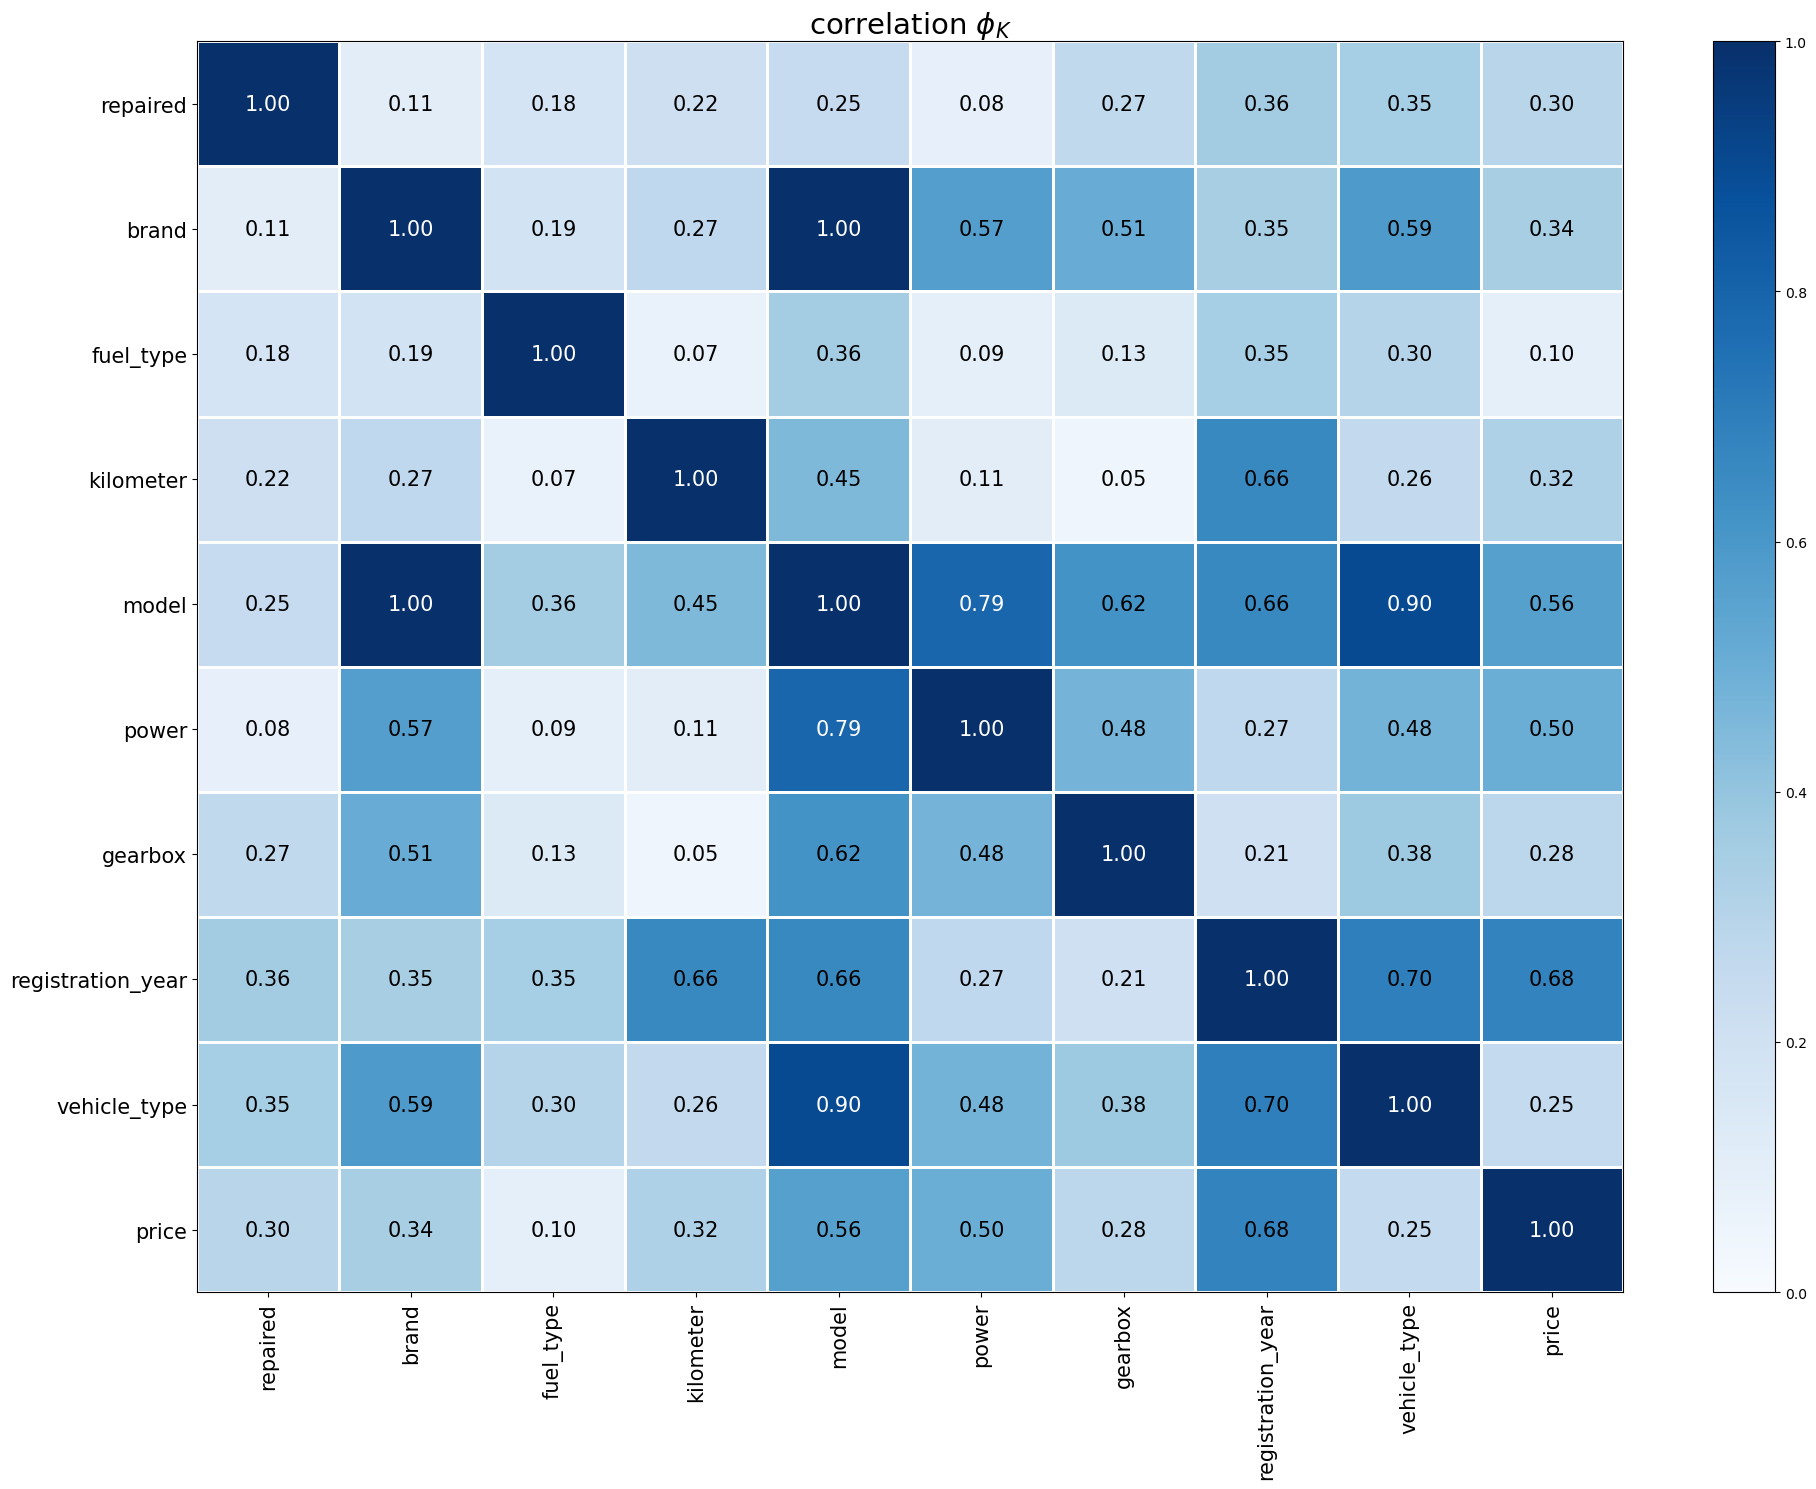

In [64]:
matrix = data_corr.phik_matrix(interval_cols=['price', 'power', 'kilometer'])

plot_correlation_matrix(
    matrix.values,
    x_labels=matrix.columns,
    y_labels=matrix.index,
    vmin=0, vmax=1, color_map='Blues',
    title=r'correlation $\phi_K$',
    fontsize_factor=1.5,
    figsize=(20, 15)
)

### Проверка мультиколлинеарности и расчет VIF

In [65]:
data_corr_vif = data_corr[['price', 'registration_year', 'power', 'kilometer']]

X = sm.add_constant(data_corr_vif)

vif = pd.DataFrame()
vif['Переменная'] = X.columns
vif['Коэффициент VIF'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

display(vif)

,Переменная,Коэффициент VIF
0,const,118497.893449
1,price,2.138943
2,registration_year,1.294714
3,power,1.594435
4,kilometer,1.404375


**Выводы:**

1. Изучение целевого признака показыват следующее. Распределение стоимости автомобилей содержит закономерность уменьшения количества автомобилей при увеличении их стоимости. Чем дороже автомобили, тем их меньше. Средняя стоимость автомобиля составляет 4416 евро. В наборе данных имелись автомобили с нулевой стоимостью, которые были исключены на этапе предобработки набра данных. Максимальная стоимость автомобиля составляет 20000 евро.


2. Сильной корреляции у целевого признака с входными нет. Слабая корреляция у цены с такими признаками как: была ли машина в ремонте, бренд, пробег, мощность, а средняя коррреляция с признаком года регистрации и близкая к средней у модели.


3. Выявлена высокая корреляция (0.9) между типом кузова и моделью, а также межуд мощностью двигателя и моделью (0.79)


4. Большой мультиколлинеарности у количественных признаков не имеется.


## Обучение моделей

### Подготовка данных

**Определяем целевой признак ('price') и входные признаки**

In [66]:
RANDOM_STATE = 42

X = data.drop('price', axis=1)
y = data['price']

**Разделение набора данных на обучающую, валидационную и тестовую выборки**

In [67]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=RANDOM_STATE)

In [68]:
data_shape = {'Выборка': ['X_train', 'X_test', 'y_train', 'y_test'], 
            'Размер': [X_train.shape, X_test.shape, y_train.shape, y_test.shape]}

display(pd.DataFrame(data_shape))

,Выборка,Размер
0,X_train,"(233176, 9)"
1,X_test,"(58294, 9)"
2,y_train,"(233176,)"
3,y_test,"(58294,)"


In [69]:
data.head()

,price,vehicle_type,registration_year,gearbox,power,model,kilometer,fuel_type,brand,repaired
1,18300,coupe,2011,manual,190,unknown,125000,petrol,audi,yes
2,9800,suv,2004,auto,163,grand,125000,petrol,jeep,unknown
3,1500,small,2001,manual,75,golf,150000,petrol,volkswagen,no
4,3600,small,2008,manual,69,fabia,90000,petrol,skoda,no
5,650,sedan,1995,manual,102,3er,150000,petrol,bmw,yes


**Создаем переменные с категориальными и количественными признаками**

In [70]:
ohe_columns = ['vehicle_type', 'gearbox', 'model', 'fuel_type', 'brand', 'repaired']
ord_columns = ['vehicle_type', 'gearbox', 'model', 'fuel_type', 'brand', 'repaired']
num_columns = ['power', 'kilometer', 'registration_year']

### LinearRegression

In [71]:
LinearRegression()._get_param_names()

['copy_X', 'fit_intercept', 'n_jobs', 'positive']

In [72]:
ohe_pipe_linear = Pipeline(
    [
        (
            'simpleImputer_ohe', 
            SimpleImputer(missing_values=np.nan, strategy='most_frequent')
        ),
        (
            'ohe', 
            OneHotEncoder(drop='first', handle_unknown='error', sparse_output=False)
        )
    ]
)

In [73]:
ohe_pipe_linear

Pipeline(steps=[('simpleImputer_ohe', SimpleImputer(strategy='most_frequent')),
                ('ohe', OneHotEncoder(drop='first', sparse_output=False))])

In [74]:
data_preprocessor_linear = ColumnTransformer(
    [
        ('ohe', ohe_pipe_linear, ohe_columns),
        ('num', MinMaxScaler(), num_columns)
    ], 
    remainder='passthrough'
)

In [75]:
data_preprocessor_linear

ColumnTransformer(remainder='passthrough',
                  transformers=[('ohe',
                                 Pipeline(steps=[('simpleImputer_ohe',
                                                  SimpleImputer(strategy='most_frequent')),
                                                 ('ohe',
                                                  OneHotEncoder(drop='first',
                                                                sparse_output=False))]),
                                 ['vehicle_type', 'gearbox', 'model',
                                  'fuel_type', 'brand', 'repaired']),
                                ('num', MinMaxScaler(),
                                 ['power', 'kilometer', 'registration_year'])])

In [76]:
pipe_final_linear = Pipeline([
    ('preprocessor', data_preprocessor_linear),  
    ('models', LinearRegression())
])

In [77]:
pipe_final_linear

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ohe',
                                                  Pipeline(steps=[('simpleImputer_ohe',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ohe',
                                                                   OneHotEncoder(drop='first',
                                                                                 sparse_output=False))]),
                                                  ['vehicle_type', 'gearbox',
                                                   'model', 'fuel_type',
                                                   'brand', 'repaired']),
                                                 ('num', MinMaxScaler(),
                                                  ['power', 'kilometer',
                                                   'registration_year'])])),
                ('models', LinearRegression())])

In [78]:
param_grid_linear = [
    {
        'models' : [LinearRegression(n_jobs=-1)],  
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough'] 
    }
]

In [79]:
param_grid_linear

[{'models': [LinearRegression(n_jobs=-1)],
  'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']}]

In [80]:
grid_search_linear = GridSearchCV(
    pipe_final_linear, 
    param_grid_linear, 
    cv=5,
    scoring='neg_root_mean_squared_error',
    n_jobs=-1    
)

In [81]:
grid_search_linear

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('ohe',
                                                                         Pipeline(steps=[('simpleImputer_ohe',
                                                                                          SimpleImputer(strategy='most_frequent')),
                                                                                         ('ohe',
                                                                                          OneHotEncoder(drop='first',
                                                                                                        sparse_output=False))]),
                                                                         ['vehicle_type',
                                                                          'gearbox',
                                                                          'model',
                                                                          'fuel_type',
                                                                          'brand',
                                                                          'repaired']),
                                                                        ('num',
                                                                         MinMaxScaler(),
                                                                         ['power',
                                                                          'kilometer',
                                                                          'registration_year'])])),
                                       ('models', LinearRegression())]),
             n_jobs=-1,
             param_grid=[{'models': [LinearRegression(n_jobs=-1)],
                          'preprocessor__num': [StandardScaler(),
                                                MinMaxScaler(),
                                                'passthrough']}],
             scoring='neg_root_mean_squared_error')

In [82]:
grid_search_linear.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('ohe',
                                                                         Pipeline(steps=[('simpleImputer_ohe',
                                                                                          SimpleImputer(strategy='most_frequent')),
                                                                                         ('ohe',
                                                                                          OneHotEncoder(drop='first',
                                                                                                        sparse_output=False))]),
                                                                         ['vehicle_type',
                                                                          'gearbox',
                                                                          'model',
                                                                          'fuel_type',
                                                                          'brand',
                                                                          'repaired']),
                                                                        ('num',
                                                                         MinMaxScaler(),
                                                                         ['power',
                                                                          'kilometer',
                                                                          'registration_year'])])),
                                       ('models', LinearRegression())]),
             n_jobs=-1,
             param_grid=[{'models': [LinearRegression(n_jobs=-1)],
                          'preprocessor__num': [StandardScaler(),
                                                MinMaxScaler(),
                                                'passthrough']}],
             scoring='neg_root_mean_squared_error')

In [83]:
grid_search_linear.cv_results_

{'mean_fit_time': array([9.57992568, 8.84338646, 7.70544624]),
 'std_fit_time': array([0.37101538, 0.06586437, 0.90507918]),
 'mean_score_time': array([0.19534831, 0.2055017 , 0.18913198]),
 'std_score_time': array([0.01257335, 0.0136388 , 0.01792988]),
 'param_models': masked_array(data=[LinearRegression(n_jobs=-1),
                    LinearRegression(n_jobs=-1),
                    LinearRegression(n_jobs=-1)],
              mask=[False, False, False],
        fill_value='?',
             dtype=object),
 'param_preprocessor__num': masked_array(data=[StandardScaler(), MinMaxScaler(), 'passthrough'],
              mask=[False, False, False],
        fill_value='?',
             dtype=object),
 'params': [{'models': LinearRegression(n_jobs=-1),
   'preprocessor__num': StandardScaler()},
  {'models': LinearRegression(n_jobs=-1), 'preprocessor__num': MinMaxScaler()},
  {'models': LinearRegression(n_jobs=-1), 'preprocessor__num': 'passthrough'}],
 'split0_test_score': array([-2554.6200937

In [84]:
df_linear = pd.DataFrame(grid_search_linear.cv_results_)
df_linear

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_models,param_preprocessor__num,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,9.579926,0.371015,0.195348,0.012573,LinearRegression(n_jobs=-1),StandardScaler(),"{'models': LinearRegression(n_jobs=-1), 'preprocessor__num': StandardScaler()}",-2554.620094,-2552.498562,-2582.007774,-2582.789429,-2568.602017,-2568.103575,12.919522,3
1,8.843386,0.065864,0.205502,0.013639,LinearRegression(n_jobs=-1),MinMaxScaler(),"{'models': LinearRegression(n_jobs=-1), 'preprocessor__num': MinMaxScaler()}",-2554.620094,-2552.498562,-2582.007774,-2582.789429,-2568.602017,-2568.103575,12.919522,2
2,7.705446,0.905079,0.189132,0.017930,LinearRegression(n_jobs=-1),passthrough,"{'models': LinearRegression(n_jobs=-1), 'preprocessor__num': 'passthrough'}",-2554.620094,-2552.498562,-2582.007774,-2582.789429,-2568.602017,-2568.103575,12.919522,1


### DecisionTreeRegressor

In [85]:
DecisionTreeRegressor()._get_param_names()

['ccp_alpha',
 'criterion',
 'max_depth',
 'max_features',
 'max_leaf_nodes',
 'min_impurity_decrease',
 'min_samples_leaf',
 'min_samples_split',
 'min_weight_fraction_leaf',
 'monotonic_cst',
 'random_state',
 'splitter']

In [86]:
ord_pipe_decisiontree = Pipeline(
    [
        (
            'simpleImputer_before_ord', 
            SimpleImputer(missing_values=np.nan, strategy='most_frequent')
        ),
        (
            'ord',
            OrdinalEncoder(categories='auto', handle_unknown='use_encoded_value', unknown_value=np.nan)
        ),
        (
            'simpleImputer_after_ord', 
            SimpleImputer(missing_values=np.nan, strategy='most_frequent')
        )
    ]
)

In [87]:
ord_pipe_decisiontree

Pipeline(steps=[('simpleImputer_before_ord',
                 SimpleImputer(strategy='most_frequent')),
                ('ord',
                 OrdinalEncoder(handle_unknown='use_encoded_value',
                                unknown_value=nan)),
                ('simpleImputer_after_ord',
                 SimpleImputer(strategy='most_frequent'))])

In [88]:
data_preprocessor_decisiontree = ColumnTransformer(
    [
        ('ord', ord_pipe_decisiontree, ord_columns),
        ('num', MinMaxScaler(), num_columns)
    ], 
    remainder='passthrough'
)

In [89]:
data_preprocessor_decisiontree

ColumnTransformer(remainder='passthrough',
                  transformers=[('ord',
                                 Pipeline(steps=[('simpleImputer_before_ord',
                                                  SimpleImputer(strategy='most_frequent')),
                                                 ('ord',
                                                  OrdinalEncoder(handle_unknown='use_encoded_value',
                                                                 unknown_value=nan)),
                                                 ('simpleImputer_after_ord',
                                                  SimpleImputer(strategy='most_frequent'))]),
                                 ['vehicle_type', 'gearbox', 'model',
                                  'fuel_type', 'brand', 'repaired']),
                                ('num', MinMaxScaler(),
                                 ['power', 'kilometer', 'registration_year'])])

In [90]:
pipe_final_decisiontree = Pipeline([
    ('preprocessor', data_preprocessor_decisiontree),
    ('models', DecisionTreeRegressor())
])

In [91]:
pipe_final_decisiontree

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ord',
                                                  Pipeline(steps=[('simpleImputer_before_ord',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ord',
                                                                   OrdinalEncoder(handle_unknown='use_encoded_value',
                                                                                  unknown_value=nan)),
                                                                  ('simpleImputer_after_ord',
                                                                   SimpleImputer(strategy='most_frequent'))]),
                                                  ['vehicle_type', 'gearbox',
                                                   'model', 'fuel_type',
                                                   'brand', 'repaired']),
                                                 ('num', MinMaxScaler(),
                                                  ['power', 'kilometer',
                                                   'registration_year'])])),
                ('models', DecisionTreeRegressor())])

In [92]:
param_grid_decisiontree = [
    {
        'models': [DecisionTreeRegressor(random_state=RANDOM_STATE)],
        'models__max_depth': range(2, 10),
        'models__max_features': range(2, 10),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']  
    }
]

In [93]:
param_grid_decisiontree

[{'models': [DecisionTreeRegressor(random_state=42)],
  'models__max_depth': range(2, 10),
  'models__max_features': range(2, 10),
  'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']}]

In [94]:
grid_search_decisiontree = GridSearchCV(
    pipe_final_decisiontree, 
    param_grid_decisiontree, 
    cv=5,
    scoring='neg_root_mean_squared_error',
    n_jobs=-1    
)

In [95]:
grid_search_decisiontree

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('ord',
                                                                         Pipeline(steps=[('simpleImputer_before_ord',
                                                                                          SimpleImputer(strategy='most_frequent')),
                                                                                         ('ord',
                                                                                          OrdinalEncoder(handle_unknown='use_encoded_value',
                                                                                                         unknown_value=nan)),
                                                                                         ('simpleImputer_after_ord',
                                                                                          SimpleImputer(strategy='most_frequent'...
                                                                        ('num',
                                                                         MinMaxScaler(),
                                                                         ['power',
                                                                          'kilometer',
                                                                          'registration_year'])])),
                                       ('models', DecisionTreeRegressor())]),
             n_jobs=-1,
             param_grid=[{'models': [DecisionTreeRegressor(random_state=42)],
                          'models__max_depth': range(2, 10),
                          'models__max_features': range(2, 10),
                          'preprocessor__num': [StandardScaler(),
                                                MinMaxScaler(),
                                                'passthrough']}],
             scoring='neg_root_mean_squared_error')

In [96]:
grid_search_decisiontree.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('ord',
                                                                         Pipeline(steps=[('simpleImputer_before_ord',
                                                                                          SimpleImputer(strategy='most_frequent')),
                                                                                         ('ord',
                                                                                          OrdinalEncoder(handle_unknown='use_encoded_value',
                                                                                                         unknown_value=nan)),
                                                                                         ('simpleImputer_after_ord',
                                                                                          SimpleImputer(strategy='most_frequent'...
                                                                        ('num',
                                                                         MinMaxScaler(),
                                                                         ['power',
                                                                          'kilometer',
                                                                          'registration_year'])])),
                                       ('models', DecisionTreeRegressor())]),
             n_jobs=-1,
             param_grid=[{'models': [DecisionTreeRegressor(random_state=42)],
                          'models__max_depth': range(2, 10),
                          'models__max_features': range(2, 10),
                          'preprocessor__num': [StandardScaler(),
                                                MinMaxScaler(),
                                                'passthrough']}],
             scoring='neg_root_mean_squared_error')

In [97]:
grid_search_decisiontree.cv_results_

{'mean_fit_time': array([0.48990712, 0.48934541, 0.51050801, 0.54800634, 0.54895816,
        0.51495905, 0.60775175, 0.54307933, 0.54541554, 0.57640624,
        0.5717205 , 0.69316688, 0.64994698, 0.61677194, 0.65002794,
        0.64079566, 0.79116173, 0.64209156, 0.58762074, 0.73009534,
        0.60899172, 0.64147286, 0.6840621 , 0.64676056, 0.59519858,
        0.51970944, 0.53197727, 0.57075911, 0.62392597, 0.63498898,
        0.6180531 , 0.72039566, 0.61108627, 0.65220547, 0.68002205,
        0.64127822, 0.63954654, 0.63947759, 0.60043297, 0.73780966,
        0.72200408, 0.7068686 , 0.67882805, 0.60986104, 0.59931021,
        0.70078177, 0.71783977, 0.6968657 , 0.63793511, 0.5462502 ,
        0.51163759, 0.57222276, 0.54159155, 0.53177347, 0.55497451,
        0.55309958, 0.55459695, 0.59578247, 0.57892761, 0.57179794,
        0.60014849, 0.60309749, 0.58324704, 0.62568369, 0.73041034,
        0.69324393, 0.76444354, 0.73186183, 0.64623661, 0.72135816,
        0.68502169, 0.66202631,

In [98]:
df_decisiontree = pd.DataFrame(grid_search_decisiontree.cv_results_)
df_decisiontree

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_models,param_models__max_depth,param_models__max_features,param_preprocessor__num,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.489907,0.007017,0.065677,0.007320,DecisionTreeRegressor(random_state=42),2,2,StandardScaler(),"{'models': DecisionTreeRegressor(random_state=42), 'models__max_depth': 2, 'models__max_features': 2, 'preprocessor__num': StandardScaler()}",-4244.460989,-4236.185354,-4227.489126,-4260.749015,-4279.764041,-4249.729705,18.597520,190
1,0.489345,0.018265,0.063190,0.004157,DecisionTreeRegressor(random_state=42),2,2,MinMaxScaler(),"{'models': DecisionTreeRegressor(random_state=42), 'models__max_depth': 2, 'models__max_features': 2, 'preprocessor__num': MinMaxScaler()}",-4244.460989,-4236.185354,-4227.489126,-4260.749015,-4279.764041,-4249.729705,18.597520,190
2,0.510508,0.019257,0.070375,0.007583,DecisionTreeRegressor(random_state=42),2,2,passthrough,"{'models': DecisionTreeRegressor(random_state=42), 'models__max_depth': 2, 'models__max_features': 2, 'preprocessor__num': 'passthrough'}",-4244.460989,-4236.185354,-4227.489126,-4260.749015,-4279.764041,-4249.729705,18.597520,190
3,0.548006,0.010501,0.072843,0.008104,DecisionTreeRegressor(random_state=42),2,3,StandardScaler(),"{'models': DecisionTreeRegressor(random_state=42), 'models__max_depth': 2, 'models__max_features': 3, 'preprocessor__num': StandardScaler()}",-3497.970992,-3476.910530,-3502.174471,-3522.734724,-3522.477182,-3504.453580,17.116590,175
4,0.548958,0.019948,0.067173,0.002378,DecisionTreeRegressor(random_state=42),2,3,MinMaxScaler(),"{'models': DecisionTreeRegressor(random_state=42), 'models__max_depth': 2, 'models__max_features': 3, 'preprocessor__num': MinMaxScaler()}",-3497.970992,-3476.910530,-3502.174471,-3522.734724,-3522.477182,-3504.453580,17.116590,175
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
187,0.803322,0.011705,0.065386,0.000633,DecisionTreeRegressor(random_state=42),9,8,MinMaxScaler(),"{'models': DecisionTreeRegressor(random_state=42), 'models__max_depth': 9, 'models__max_features': 8, 'preprocessor__num': MinMaxScaler()}",-2027.217026,-2030.350829,-2060.972386,-2050.277295,-2055.752117,-2044.913931,13.633564,6
188,0.789219,0.021131,0.063869,0.001058,DecisionTreeRegressor(random_state=42),9,8,passthrough,"{'models': DecisionTreeRegressor(random_state=42), 'models__max_depth': 9, 'models__max_features': 8, 'preprocessor__num': 'passthrough'}",-2027.162357,-2030.350829,-2060.972386,-2050.198398,-2055.752117,-2044.887217,13.641588,5
189,0.841600,0.017262,0.067095,0.001967,DecisionTreeRegressor(random_state=42),9,9,StandardScaler(),"{'models': DecisionTreeRegressor(random_state=42), 'models__max_depth': 9, 'models__max_features': 9, 'preprocessor__num': StandardScaler()}",-2018.749636,-2035.902709,-2068.165875,-2042.832265,-2050.106883,-2043.151474,16.261575,3
190,0.842610,0.021537,0.065887,0.001306,DecisionTreeRegressor(random_state=42),9,9,MinMaxScaler(),"{'models': DecisionTreeRegressor(random_state=42), 'models__max_depth': 9, 'models__max_features': 9, 'preprocessor__num': MinMaxScaler()}",-2018.632058,-2034.993625,-2068.165875,-2042.550481,-2049.606759,-2042.789760,16.339218,2


### CatBoostRegressor

In [99]:
CatBoostRegressor().get_params()

{'loss_function': 'RMSE'}

In [100]:
ord_pipe_catboost = Pipeline(
    [
        (
            'simpleImputer_before_ord', 
            SimpleImputer(missing_values=np.nan, strategy='most_frequent')
        ),
        (
            'ord',
            OrdinalEncoder(categories='auto', handle_unknown='use_encoded_value', unknown_value=np.nan)
        ),
        (
            'simpleImputer_after_ord', 
            SimpleImputer(missing_values=np.nan, strategy='most_frequent')
        )
    ]
)

In [101]:
ord_pipe_catboost

Pipeline(steps=[('simpleImputer_before_ord',
                 SimpleImputer(strategy='most_frequent')),
                ('ord',
                 OrdinalEncoder(handle_unknown='use_encoded_value',
                                unknown_value=nan)),
                ('simpleImputer_after_ord',
                 SimpleImputer(strategy='most_frequent'))])

In [102]:
data_preprocessor_catboost = ColumnTransformer(
    [
        ('ord', ord_pipe_catboost, ord_columns),
        ('num', MinMaxScaler(), num_columns)
    ], 
    remainder='passthrough'
)

In [103]:
data_preprocessor_catboost

ColumnTransformer(remainder='passthrough',
                  transformers=[('ord',
                                 Pipeline(steps=[('simpleImputer_before_ord',
                                                  SimpleImputer(strategy='most_frequent')),
                                                 ('ord',
                                                  OrdinalEncoder(handle_unknown='use_encoded_value',
                                                                 unknown_value=nan)),
                                                 ('simpleImputer_after_ord',
                                                  SimpleImputer(strategy='most_frequent'))]),
                                 ['vehicle_type', 'gearbox', 'model',
                                  'fuel_type', 'brand', 'repaired']),
                                ('num', MinMaxScaler(),
                                 ['power', 'kilometer', 'registration_year'])])

In [104]:
pipe_final_catboost = Pipeline([
    ('preprocessor', data_preprocessor_catboost),
    ('models', CatBoostRegressor())
])

In [105]:
pipe_final_catboost

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ord',
                                                  Pipeline(steps=[('simpleImputer_before_ord',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ord',
                                                                   OrdinalEncoder(handle_unknown='use_encoded_value',
                                                                                  unknown_value=nan)),
                                                                  ('simpleImputer_after_ord',
                                                                   SimpleImputer(strategy='most_frequent'))]),
                                                  ['vehicle_type', 'gearbox',
                                                   'model', 'fuel_type',
                                                   'brand', 'repaired']),
                                                 ('num', MinMaxScaler(),
                                                  ['power', 'kilometer',
                                                   'registration_year'])])),
                ('models',
                 <catboost.core.CatBoostRegressor object at 0x00000167B94EF110>)])

In [106]:
param_grid_catboost = [
    {
        'models': [CatBoostRegressor(random_state=RANDOM_STATE)],
        'models__max_depth': range(2, 5), 
        'models__learning_rate': [0.3, 0.5],
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough'] 
    }
   
]

In [107]:
param_grid_catboost

[{'models': [<catboost.core.CatBoostRegressor at 0x16792b8b190>],
  'models__max_depth': range(2, 5),
  'models__learning_rate': [0.3, 0.5],
  'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']}]

In [108]:
grid_search_catboost = GridSearchCV(
    pipe_final_catboost, 
    param_grid_catboost, 
    cv=5,
    scoring='neg_root_mean_squared_error',
    n_jobs=-1, 
    verbose=True
)

In [109]:
grid_search_catboost

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('ord',
                                                                         Pipeline(steps=[('simpleImputer_before_ord',
                                                                                          SimpleImputer(strategy='most_frequent')),
                                                                                         ('ord',
                                                                                          OrdinalEncoder(handle_unknown='use_encoded_value',
                                                                                                         unknown_value=nan)),
                                                                                         ('simpleImputer_after_ord',
                                                                                          SimpleImputer(strategy='most_frequent'...
                                       ('models',
                                        <catboost.core.CatBoostRegressor object at 0x00000167B94EF110>)]),
             n_jobs=-1,
             param_grid=[{'models': [<catboost.core.CatBoostRegressor object at 0x0000016792B8B190>],
                          'models__learning_rate': [0.3, 0.5],
                          'models__max_depth': range(2, 5),
                          'preprocessor__num': [StandardScaler(),
                                                MinMaxScaler(),
                                                'passthrough']}],
             scoring='neg_root_mean_squared_error', verbose=True)

In [110]:
grid_search_catboost.fit(X_train, y_train)

Fitting 5 folds for each of 18 candidates, totalling 90 fits
0:	learn: 3434.1468043	total: 159ms	remaining: 2m 38s
1:	learn: 2896.9217439	total: 176ms	remaining: 1m 27s
2:	learn: 2565.2447421	total: 192ms	remaining: 1m 3s
3:	learn: 2404.4580715	total: 209ms	remaining: 52.1s
4:	learn: 2315.8821619	total: 226ms	remaining: 44.9s
5:	learn: 2262.5950068	total: 244ms	remaining: 40.5s
6:	learn: 2201.4102178	total: 260ms	remaining: 36.9s
7:	learn: 2156.1204277	total: 278ms	remaining: 34.4s
8:	learn: 2125.2073417	total: 293ms	remaining: 32.3s
9:	learn: 2092.7128538	total: 310ms	remaining: 30.7s
10:	learn: 2067.1112631	total: 328ms	remaining: 29.5s
11:	learn: 2052.1776957	total: 344ms	remaining: 28.3s
12:	learn: 2028.8368336	total: 362ms	remaining: 27.4s
13:	learn: 2015.9345960	total: 379ms	remaining: 26.7s
14:	learn: 1999.3985360	total: 396ms	remaining: 26s
15:	learn: 1990.6049150	total: 413ms	remaining: 25.4s
16:	learn: 1981.0500308	total: 428ms	remaining: 24.8s
17:	learn: 1970.7221330	total: 

161:	learn: 1685.9347815	total: 2.51s	remaining: 13s
162:	learn: 1685.4579812	total: 2.52s	remaining: 13s
163:	learn: 1685.1328619	total: 2.54s	remaining: 12.9s
164:	learn: 1684.1466745	total: 2.55s	remaining: 12.9s
165:	learn: 1683.4348525	total: 2.56s	remaining: 12.9s
166:	learn: 1682.6824431	total: 2.58s	remaining: 12.9s
167:	learn: 1682.2420176	total: 2.59s	remaining: 12.8s
168:	learn: 1680.9811764	total: 2.6s	remaining: 12.8s
169:	learn: 1680.3477849	total: 2.62s	remaining: 12.8s
170:	learn: 1679.7693496	total: 2.63s	remaining: 12.8s
171:	learn: 1679.1762709	total: 2.65s	remaining: 12.7s
172:	learn: 1678.5017680	total: 2.66s	remaining: 12.7s
173:	learn: 1677.8129228	total: 2.67s	remaining: 12.7s
174:	learn: 1677.1073876	total: 2.69s	remaining: 12.7s
175:	learn: 1676.4090976	total: 2.7s	remaining: 12.7s
176:	learn: 1675.9432515	total: 2.71s	remaining: 12.6s
177:	learn: 1675.0640752	total: 2.73s	remaining: 12.6s
178:	learn: 1673.2883494	total: 2.74s	remaining: 12.6s
179:	learn: 1672

319:	learn: 1615.0352087	total: 4.6s	remaining: 9.77s
320:	learn: 1614.8008133	total: 4.61s	remaining: 9.75s
321:	learn: 1614.4833035	total: 4.62s	remaining: 9.73s
322:	learn: 1614.3254384	total: 4.63s	remaining: 9.72s
323:	learn: 1614.0482763	total: 4.65s	remaining: 9.7s
324:	learn: 1613.6955982	total: 4.67s	remaining: 9.7s
325:	learn: 1613.5424933	total: 4.68s	remaining: 9.68s
326:	learn: 1613.2425921	total: 4.7s	remaining: 9.67s
327:	learn: 1613.0656876	total: 4.71s	remaining: 9.65s
328:	learn: 1612.9034753	total: 4.72s	remaining: 9.63s
329:	learn: 1612.6603377	total: 4.73s	remaining: 9.61s
330:	learn: 1612.4123576	total: 4.74s	remaining: 9.59s
331:	learn: 1612.0998339	total: 4.76s	remaining: 9.57s
332:	learn: 1611.7981558	total: 4.77s	remaining: 9.56s
333:	learn: 1611.4509911	total: 4.79s	remaining: 9.54s
334:	learn: 1611.1541390	total: 4.8s	remaining: 9.52s
335:	learn: 1610.8078170	total: 4.81s	remaining: 9.51s
336:	learn: 1610.5894643	total: 4.82s	remaining: 9.49s
337:	learn: 161

482:	learn: 1577.2661086	total: 6.73s	remaining: 7.2s
483:	learn: 1577.0487741	total: 6.74s	remaining: 7.19s
484:	learn: 1576.6913297	total: 6.76s	remaining: 7.18s
485:	learn: 1576.3901472	total: 6.77s	remaining: 7.16s
486:	learn: 1576.2366674	total: 6.79s	remaining: 7.15s
487:	learn: 1576.1067196	total: 6.8s	remaining: 7.13s
488:	learn: 1576.0258422	total: 6.81s	remaining: 7.12s
489:	learn: 1575.8994719	total: 6.83s	remaining: 7.11s
490:	learn: 1575.6934594	total: 6.84s	remaining: 7.09s
491:	learn: 1575.4849836	total: 6.85s	remaining: 7.08s
492:	learn: 1575.3077367	total: 6.87s	remaining: 7.06s
493:	learn: 1574.9407582	total: 6.88s	remaining: 7.05s
494:	learn: 1574.8216357	total: 6.89s	remaining: 7.03s
495:	learn: 1574.6870659	total: 6.91s	remaining: 7.02s
496:	learn: 1574.4878172	total: 6.92s	remaining: 7s
497:	learn: 1574.4145863	total: 6.93s	remaining: 6.98s
498:	learn: 1574.0678148	total: 6.94s	remaining: 6.97s
499:	learn: 1573.9856486	total: 6.95s	remaining: 6.95s
500:	learn: 157

642:	learn: 1550.4458405	total: 8.85s	remaining: 4.91s
643:	learn: 1550.2654254	total: 8.86s	remaining: 4.9s
644:	learn: 1550.0252300	total: 8.88s	remaining: 4.88s
645:	learn: 1549.8744837	total: 8.89s	remaining: 4.87s
646:	learn: 1549.7215815	total: 8.9s	remaining: 4.86s
647:	learn: 1549.5622526	total: 8.91s	remaining: 4.84s
648:	learn: 1549.3145742	total: 8.93s	remaining: 4.83s
649:	learn: 1549.1392967	total: 8.94s	remaining: 4.81s
650:	learn: 1548.9624143	total: 8.95s	remaining: 4.8s
651:	learn: 1548.7298697	total: 8.97s	remaining: 4.79s
652:	learn: 1548.6313742	total: 8.98s	remaining: 4.77s
653:	learn: 1548.3783880	total: 9s	remaining: 4.76s
654:	learn: 1548.2618079	total: 9.02s	remaining: 4.75s
655:	learn: 1548.1444207	total: 9.03s	remaining: 4.73s
656:	learn: 1547.8983037	total: 9.04s	remaining: 4.72s
657:	learn: 1547.7709756	total: 9.05s	remaining: 4.71s
658:	learn: 1547.6939184	total: 9.06s	remaining: 4.69s
659:	learn: 1547.5450611	total: 9.08s	remaining: 4.68s
660:	learn: 1547

794:	learn: 1528.8983551	total: 11s	remaining: 2.83s
795:	learn: 1528.7871956	total: 11s	remaining: 2.82s
796:	learn: 1528.6299649	total: 11s	remaining: 2.8s
797:	learn: 1528.5271751	total: 11s	remaining: 2.79s
798:	learn: 1528.3693484	total: 11s	remaining: 2.78s
799:	learn: 1528.2980542	total: 11.1s	remaining: 2.77s
800:	learn: 1528.2163170	total: 11.1s	remaining: 2.75s
801:	learn: 1528.1089820	total: 11.1s	remaining: 2.74s
802:	learn: 1527.9082544	total: 11.1s	remaining: 2.73s
803:	learn: 1527.7755644	total: 11.1s	remaining: 2.71s
804:	learn: 1527.6829186	total: 11.1s	remaining: 2.7s
805:	learn: 1527.5892222	total: 11.2s	remaining: 2.69s
806:	learn: 1527.4537242	total: 11.2s	remaining: 2.67s
807:	learn: 1527.3255777	total: 11.2s	remaining: 2.66s
808:	learn: 1527.2583698	total: 11.2s	remaining: 2.65s
809:	learn: 1527.1919051	total: 11.2s	remaining: 2.63s
810:	learn: 1527.1071762	total: 11.2s	remaining: 2.62s
811:	learn: 1526.9871968	total: 11.3s	remaining: 2.6s
812:	learn: 1526.813261

944:	learn: 1512.7520473	total: 13.3s	remaining: 776ms
945:	learn: 1512.6075071	total: 13.3s	remaining: 762ms
946:	learn: 1512.5438209	total: 13.4s	remaining: 748ms
947:	learn: 1512.4948407	total: 13.4s	remaining: 734ms
948:	learn: 1512.4595910	total: 13.4s	remaining: 719ms
949:	learn: 1512.4291749	total: 13.4s	remaining: 705ms
950:	learn: 1512.3309601	total: 13.4s	remaining: 691ms
951:	learn: 1512.3194116	total: 13.4s	remaining: 677ms
952:	learn: 1512.0986507	total: 13.4s	remaining: 663ms
953:	learn: 1511.9942353	total: 13.5s	remaining: 649ms
954:	learn: 1511.9480480	total: 13.5s	remaining: 635ms
955:	learn: 1511.8130950	total: 13.5s	remaining: 621ms
956:	learn: 1511.5998464	total: 13.5s	remaining: 607ms
957:	learn: 1511.5003077	total: 13.5s	remaining: 593ms
958:	learn: 1511.4130848	total: 13.5s	remaining: 578ms
959:	learn: 1511.3653360	total: 13.5s	remaining: 565ms
960:	learn: 1511.1634210	total: 13.6s	remaining: 550ms
961:	learn: 1511.0302933	total: 13.6s	remaining: 536ms
962:	learn

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('ord',
                                                                         Pipeline(steps=[('simpleImputer_before_ord',
                                                                                          SimpleImputer(strategy='most_frequent')),
                                                                                         ('ord',
                                                                                          OrdinalEncoder(handle_unknown='use_encoded_value',
                                                                                                         unknown_value=nan)),
                                                                                         ('simpleImputer_after_ord',
                                                                                          SimpleImputer(strategy='most_frequent'...
                                       ('models',
                                        <catboost.core.CatBoostRegressor object at 0x00000167B94EF110>)]),
             n_jobs=-1,
             param_grid=[{'models': [<catboost.core.CatBoostRegressor object at 0x0000016792B8B190>],
                          'models__learning_rate': [0.3, 0.5],
                          'models__max_depth': range(2, 5),
                          'preprocessor__num': [StandardScaler(),
                                                MinMaxScaler(),
                                                'passthrough']}],
             scoring='neg_root_mean_squared_error', verbose=True)

In [111]:
grid_search_catboost.cv_results_

{'mean_fit_time': array([28.94944453, 30.05528092, 26.63760929, 28.20736756, 27.9896215 ,
        28.20638285, 31.89298038, 31.84100432, 31.71099877, 24.51864743,
        24.65856028, 24.46412444, 27.9547502 , 28.07161088, 27.88554254,
        31.61201444, 31.78125176, 27.13825555]),
 'std_fit_time': array([0.77360107, 1.71678752, 1.04484716, 0.34732368, 0.32910106,
        0.21448809, 0.24042355, 0.10463674, 0.25421334, 0.3544506 ,
        0.30472389, 0.21716   , 0.35809128, 0.37174314, 0.38881323,
        0.12388747, 0.09907047, 4.90325714]),
 'mean_score_time': array([0.3004149 , 0.2514369 , 0.19264941, 0.2253664 , 0.21862216,
        0.19682374, 0.20340204, 0.20013909, 0.20170655, 0.20596447,
        0.20467081, 0.22086267, 0.22623906, 0.2078577 , 0.21698632,
        0.21603117, 0.2223331 , 0.20020394]),
 'std_score_time': array([0.01234797, 0.07311789, 0.00961938, 0.02085685, 0.03360964,
        0.00593756, 0.00409616, 0.00424848, 0.00695565, 0.00759527,
        0.00552255, 0.0293

In [112]:
df_catboost = pd.DataFrame(grid_search_catboost.cv_results_)
df_catboost

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_models,param_models__learning_rate,param_models__max_depth,param_preprocessor__num,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,28.949445,0.773601,0.300415,0.012348,<catboost.core.CatBoostRegressor object at 0x0000016792B8B190>,0.3,2,StandardScaler(),"{'models': <catboost.core.CatBoostRegressor object at 0x0000016792B8B190>, 'models__learning_rate': 0.3, 'models__max_depth': 2, 'preprocessor__num': StandardScaler()}",-1734.991176,-1740.488330,-1761.503925,-1767.132215,-1755.510417,-1751.925213,12.275359,16
1,30.055281,1.716788,0.251437,0.073118,<catboost.core.CatBoostRegressor object at 0x0000016792B8B190>,0.3,2,MinMaxScaler(),"{'models': <catboost.core.CatBoostRegressor object at 0x0000016792B8B190>, 'models__learning_rate': 0.3, 'models__max_depth': 2, 'preprocessor__num': MinMaxScaler()}",-1734.991176,-1740.488330,-1761.509626,-1767.132215,-1755.510417,-1751.926353,12.276249,17
2,26.637609,1.044847,0.192649,0.009619,<catboost.core.CatBoostRegressor object at 0x0000016792B8B190>,0.3,2,passthrough,"{'models': <catboost.core.CatBoostRegressor object at 0x0000016792B8B190>, 'models__learning_rate': 0.3, 'models__max_depth': 2, 'preprocessor__num': 'passthrough'}",-1734.991176,-1740.488330,-1761.509626,-1767.132215,-1755.510417,-1751.926353,12.276249,17
3,28.207368,0.347324,0.225366,0.020857,<catboost.core.CatBoostRegressor object at 0x0000016792B8B190>,0.3,3,StandardScaler(),"{'models': <catboost.core.CatBoostRegressor object at 0x0000016792B8B190>, 'models__learning_rate': 0.3, 'models__max_depth': 3, 'preprocessor__num': StandardScaler()}",-1644.715377,-1653.697070,-1677.123029,-1677.738473,-1661.900253,-1663.034840,12.951895,10
4,27.989621,0.329101,0.218622,0.033610,<catboost.core.CatBoostRegressor object at 0x0000016792B8B190>,0.3,3,MinMaxScaler(),"{'models': <catboost.core.CatBoostRegressor object at 0x0000016792B8B190>, 'models__learning_rate': 0.3, 'models__max_depth': 3, 'preprocessor__num': MinMaxScaler()}",-1644.715377,-1653.697070,-1677.126652,-1677.738473,-1661.900253,-1663.035565,12.952683,11
5,28.206383,0.214488,0.196824,0.005938,<catboost.core.CatBoostRegressor object at 0x0000016792B8B190>,0.3,3,passthrough,"{'models': <catboost.core.CatBoostRegressor object at 0x0000016792B8B190>, 'models__learning_rate': 0.3, 'models__max_depth': 3, 'preprocessor__num': 'passthrough'}",-1644.715377,-1653.697070,-1677.126652,-1677.738473,-1661.900253,-1663.035565,12.952683,11
6,31.892980,0.240424,0.203402,0.004096,<catboost.core.CatBoostRegressor object at 0x0000016792B8B190>,0.3,4,StandardScaler(),"{'models': <catboost.core.CatBoostRegressor object at 0x0000016792B8B190>, 'models__learning_rate': 0.3, 'models__max_depth': 4, 'preprocessor__num': StandardScaler()}",-1592.220870,-1616.044039,-1635.584659,-1641.545867,-1616.041627,-1620.287412,17.376371,4
7,31.841004,0.104637,0.200139,0.004248,<catboost.core.CatBoostRegressor object at 0x0000016792B8B190>,0.3,4,MinMaxScaler(),"{'models': <catboost.core.CatBoostRegressor object at 0x0000016792B8B190>, 'models__learning_rate': 0.3, 'models__max_depth': 4, 'preprocessor__num': MinMaxScaler()}",-1592.220870,-1616.044039,-1635.591671,-1641.545867,-1616.041627,-1620.288815,17.377606,5
8,31.710999,0.254213,0.201707,0.006956,<catboost.core.CatBoostRegressor object at 0x0000016792B8B190>,0.3,4,passthrough,"{'models': <catboost.core.CatBoostRegressor object at 0x0000016792B8B190>, 'models__learning_rate': 0.3, 'models__max_depth': 4, 'preprocessor__num': 'passthrough'}",-1592.220870,-1616.044039,-1635.591671,-1641.545867,-1616.041627,-1620.288815,17.377606,5
9,24.518647,0.354451,0.205964,0.007595,<catboost.core.CatBoostRegressor object at 0x0000016792B8B190>,0.5,2,StandardScaler(),"{'models': <catboost.core.CatBoostRegressor object at 0x0000016792B8B190>, 'models__learning_rate': 0.5, 'models__max_depth': 2, 'preprocessor__num

### LGBMRegressor

In [113]:
LGBMRegressor()._get_param_names()

['boosting_type',
 'class_weight',
 'colsample_bytree',
 'importance_type',
 'learning_rate',
 'max_depth',
 'min_child_samples',
 'min_child_weight',
 'min_split_gain',
 'n_estimators',
 'n_jobs',
 'num_leaves',
 'objective',
 'random_state',
 'reg_alpha',
 'reg_lambda',
 'subsample',
 'subsample_for_bin',
 'subsample_freq']

In [114]:
ord_pipe_lgbm = Pipeline(
    [
        (
            'simpleImputer_before_ord', 
            SimpleImputer(missing_values=np.nan, strategy='most_frequent')
        ),
        (
            'ord',
            OrdinalEncoder(categories='auto', handle_unknown='use_encoded_value', unknown_value=np.nan)
        ),
        (
            'simpleImputer_after_ord', 
            SimpleImputer(missing_values=np.nan, strategy='most_frequent')
        )
    ]
)

In [115]:
ord_pipe_lgbm

Pipeline(steps=[('simpleImputer_before_ord',
                 SimpleImputer(strategy='most_frequent')),
                ('ord',
                 OrdinalEncoder(handle_unknown='use_encoded_value',
                                unknown_value=nan)),
                ('simpleImputer_after_ord',
                 SimpleImputer(strategy='most_frequent'))])

In [116]:
data_preprocessor_lgbm = ColumnTransformer(
    [
        ('ord', ord_pipe_lgbm, ord_columns),
        ('num', MinMaxScaler(), num_columns)
    ], 
    remainder='passthrough'
)

In [117]:
data_preprocessor_lgbm

ColumnTransformer(remainder='passthrough',
                  transformers=[('ord',
                                 Pipeline(steps=[('simpleImputer_before_ord',
                                                  SimpleImputer(strategy='most_frequent')),
                                                 ('ord',
                                                  OrdinalEncoder(handle_unknown='use_encoded_value',
                                                                 unknown_value=nan)),
                                                 ('simpleImputer_after_ord',
                                                  SimpleImputer(strategy='most_frequent'))]),
                                 ['vehicle_type', 'gearbox', 'model',
                                  'fuel_type', 'brand', 'repaired']),
                                ('num', MinMaxScaler(),
                                 ['power', 'kilometer', 'registration_year'])])

In [118]:
pipe_final_lgbm = Pipeline([
    ('preprocessor', data_preprocessor_lgbm),
    ('models', LGBMRegressor())
])

In [119]:
pipe_final_lgbm

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ord',
                                                  Pipeline(steps=[('simpleImputer_before_ord',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ord',
                                                                   OrdinalEncoder(handle_unknown='use_encoded_value',
                                                                                  unknown_value=nan)),
                                                                  ('simpleImputer_after_ord',
                                                                   SimpleImputer(strategy='most_frequent'))]),
                                                  ['vehicle_type', 'gearbox',
                                                   'model', 'fuel_type',
                                                   'brand', 'repaired']),
                                                 ('num', MinMaxScaler(),
                                                  ['power', 'kilometer',
                                                   'registration_year'])])),
                ('models', LGBMRegressor())])

In [120]:
param_grid_lgbm = [
    {
        'models': [LGBMRegressor(random_state=RANDOM_STATE)],
        'models__max_depth': [4, 6],
        'models__min_samples_leaf': [4, 6],
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough'] 
    }
   
]

In [121]:
param_grid_lgbm

[{'models': [LGBMRegressor(random_state=42)],
  'models__max_depth': [4, 6],
  'models__min_samples_leaf': [4, 6],
  'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']}]

In [122]:
grid_search_lgbm = GridSearchCV(
    pipe_final_lgbm, 
    param_grid_lgbm, 
    cv=5,
    scoring='neg_root_mean_squared_error',
    n_jobs=-1    
)

In [123]:
grid_search_lgbm

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('ord',
                                                                         Pipeline(steps=[('simpleImputer_before_ord',
                                                                                          SimpleImputer(strategy='most_frequent')),
                                                                                         ('ord',
                                                                                          OrdinalEncoder(handle_unknown='use_encoded_value',
                                                                                                         unknown_value=nan)),
                                                                                         ('simpleImputer_after_ord',
                                                                                          SimpleImputer(strategy='most_frequent'...
                                                                          'brand',
                                                                          'repaired']),
                                                                        ('num',
                                                                         MinMaxScaler(),
                                                                         ['power',
                                                                          'kilometer',
                                                                          'registration_year'])])),
                                       ('models', LGBMRegressor())]),
             n_jobs=-1,
             param_grid=[{'models': [LGBMRegressor(random_state=42)],
                          'models__max_depth': [4, 6],
                          'models__min_samples_leaf': [4, 6],
                          'preprocessor__num': [StandardScaler(),
                                                MinMaxScaler(),
                                                'passthrough']}],
             scoring='neg_root_mean_squared_error')

In [124]:
grid_search_lgbm.fit(X_train, y_train)

[LightGBM] [Warning] min_data_in_leaf is set with min_child_samples=20, will be overridden by min_samples_leaf=4. Current value: min_data_in_leaf=4
[LightGBM] [Warning] min_data_in_leaf is set with min_child_samples=20, will be overridden by min_samples_leaf=4. Current value: min_data_in_leaf=4
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.011945 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 597
[LightGBM] [Info] Number of data points in the train set: 233176, number of used features: 9
[LightGBM] [Info] Start training from score 5000.085125


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('ord',
                                                                         Pipeline(steps=[('simpleImputer_before_ord',
                                                                                          SimpleImputer(strategy='most_frequent')),
                                                                                         ('ord',
                                                                                          OrdinalEncoder(handle_unknown='use_encoded_value',
                                                                                                         unknown_value=nan)),
                                                                                         ('simpleImputer_after_ord',
                                                                                          SimpleImputer(strategy='most_frequent'...
                                                                          'brand',
                                                                          'repaired']),
                                                                        ('num',
                                                                         MinMaxScaler(),
                                                                         ['power',
                                                                          'kilometer',
                                                                          'registration_year'])])),
                                       ('models', LGBMRegressor())]),
             n_jobs=-1,
             param_grid=[{'models': [LGBMRegressor(random_state=42)],
                          'models__max_depth': [4, 6],
                          'models__min_samples_leaf': [4, 6],
                          'preprocessor__num': [StandardScaler(),
                                                MinMaxScaler(),
                                                'passthrough']}],
             scoring='neg_root_mean_squared_error')

In [125]:
grid_search_lgbm.cv_results_

{'mean_fit_time': array([2.00549121, 1.70435905, 2.30716786, 2.02630448, 1.88950844,
        1.85577269, 2.84888744, 2.3285697 , 2.73791795, 2.33910217,
        2.30317712, 2.45370107]),
 'std_fit_time': array([0.12376037, 0.01657097, 0.35523563, 0.14870124, 0.0520342 ,
        0.07671808, 0.38070034, 0.5075013 , 0.2942958 , 0.27759655,
        0.16681156, 0.13165013]),
 'mean_score_time': array([0.30474544, 0.24739275, 0.18413348, 0.15929132, 0.1441977 ,
        0.14641504, 0.20180593, 0.21813974, 0.22364564, 0.22675643,
        0.23771172, 0.29051118]),
 'std_score_time': array([0.00194322, 0.04903298, 0.03333677, 0.02222786, 0.01249406,
        0.0040021 , 0.06534429, 0.04933449, 0.04441464, 0.08538207,
        0.04302151, 0.0504391 ]),
 'param_models': masked_array(data=[LGBMRegressor(random_state=42),
                    LGBMRegressor(random_state=42),
                    LGBMRegressor(random_state=42),
                    LGBMRegressor(random_state=42),
                    LGBMRe

In [126]:
df_lgbm = pd.DataFrame(grid_search_lgbm.cv_results_)
df_lgbm

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_models,param_models__max_depth,param_models__min_samples_leaf,param_preprocessor__num,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,2.005491,0.123760,0.304745,0.001943,LGBMRegressor(random_state=42),4,4,StandardScaler(),"{'models': LGBMRegressor(random_state=42), 'models__max_depth': 4, 'models__min_samples_leaf': 4, 'preprocessor__num': StandardScaler()}",-1797.689226,-1810.436873,-1832.773902,-1835.306649,-1825.861224,-1820.413575,14.284179,9
1,1.704359,0.016571,0.247393,0.049033,LGBMRegressor(random_state=42),4,4,MinMaxScaler(),"{'models': LGBMRegressor(random_state=42), 'models__max_depth': 4, 'models__min_samples_leaf': 4, 'preprocessor__num': MinMaxScaler()}",-1794.406108,-1810.624101,-1834.250697,-1835.078106,-1825.064261,-1819.884655,15.485262,7
2,2.307168,0.355236,0.184133,0.033337,LGBMRegressor(random_state=42),4,4,passthrough,"{'models': LGBMRegressor(random_state=42), 'models__max_depth': 4, 'models__min_samples_leaf': 4, 'preprocessor__num': 'passthrough'}",-1794.406108,-1810.624101,-1832.599930,-1839.741401,-1825.064261,-1820.487160,16.222799,10
3,2.026304,0.148701,0.159291,0.022228,LGBMRegressor(random_state=42),4,6,StandardScaler(),"{'models': LGBMRegressor(random_state=42), 'models__max_depth': 4, 'models__min_samples_leaf': 6, 'preprocessor__num': StandardScaler()}",-1797.300785,-1811.823939,-1835.028634,-1835.290424,-1828.372203,-1821.563197,14.829937,12
4,1.889508,0.052034,0.144198,0.012494,LGBMRegressor(random_state=42),4,6,MinMaxScaler(),"{'models': LGBMRegressor(random_state=42), 'models__max_depth': 4, 'models__min_samples_leaf': 6, 'preprocessor__num': MinMaxScaler()}",-1796.697050,-1808.560549,-1838.013388,-1837.530741,-1825.842409,-1821.328827,16.315651,11
5,1.855773,0.076718,0.146415,0.004002,LGBMRegressor(random_state=42),4,6,passthrough,"{'models': LGBMRegressor(random_state=42), 'models__max_depth': 4, 'models__min_samples_leaf': 6, 'preprocessor__num': 'passthrough'}",-1796.697050,-1808.560549,-1831.472774,-1839.209467,-1825.842409,-1820.356450,15.543585,8
6,2.848887,0.380700,0.201806,0.065344,LGBMRegressor(random_state=42),6,4,StandardScaler(),"{'models': LGBMRegressor(random_state=42), 'models__max_depth': 6, 'models__min_samples_leaf': 4, 'preprocessor__num': StandardScaler()}",-1696.702955,-1713.336656,-1736.008910,-1732.722608,-1723.393410,-1720.432908,14.253986,1
7,2.328570,0.507501,0.218140,0.049334,LGBMRegressor(random_state=42),6,4,MinMaxScaler(),"{'models': LGBMRegressor(random_state=42), 'models__max_depth': 6, 'models__min_samples_leaf': 4, 'preprocessor__num': MinMaxScaler()}",-1703.346811,-1717.396372,-1737.909326,-1735.532620,-1725.674977,-1723.972021,12.644639,5
8,2.737918,0.294296,0.223646,0.044415,LGBMRegressor(random_state=42),6,4,passthrough,"{'models': LGBMRegressor(random_state=42), 'models__max_depth': 6, 'models__min_samples_leaf': 4, 'preprocessor__num': 'passthrough'}",-1703.346811,-1717.396372,-1737.909030,-1736.729021,-1725.674977,-1724.211242,12.870382,6
9,2.339102,0.277597,0.226756,0.085382,LGBMRegressor(random_state=42),6,6,StandardScaler(),"{'models': LGBMRegressor(random_state=42), 'models__max_depth': 6, 'models__min_samples_leaf': 6, 'preprocessor__num': StandardScaler()}",-1699.575694,-1719.268910,-1738.230008,-1735.868684,-1723.630627,-1723.314785,13.856966,2


### XGBRegressor

In [127]:
XGBRegressor()._get_param_names()

['objective']

In [128]:
ord_pipe_xgb = Pipeline(
    [
        (
            'simpleImputer_before_ord', 
            SimpleImputer(missing_values=np.nan, strategy='most_frequent')
        ),
        (
            'ord',
            OrdinalEncoder(categories='auto', handle_unknown='use_encoded_value', unknown_value=np.nan)
        ),
        (
            'simpleImputer_after_ord', 
            SimpleImputer(missing_values=np.nan, strategy='most_frequent')
        )
    ]
)

In [129]:
ord_pipe_xgb

Pipeline(steps=[('simpleImputer_before_ord',
                 SimpleImputer(strategy='most_frequent')),
                ('ord',
                 OrdinalEncoder(handle_unknown='use_encoded_value',
                                unknown_value=nan)),
                ('simpleImputer_after_ord',
                 SimpleImputer(strategy='most_frequent'))])

In [130]:
data_preprocessor_xgb = ColumnTransformer(
    [
        ('ord', ord_pipe_xgb, ord_columns),
        ('num', MinMaxScaler(), num_columns)
    ], 
    remainder='passthrough'
)

In [131]:
data_preprocessor_xgb

ColumnTransformer(remainder='passthrough',
                  transformers=[('ord',
                                 Pipeline(steps=[('simpleImputer_before_ord',
                                                  SimpleImputer(strategy='most_frequent')),
                                                 ('ord',
                                                  OrdinalEncoder(handle_unknown='use_encoded_value',
                                                                 unknown_value=nan)),
                                                 ('simpleImputer_after_ord',
                                                  SimpleImputer(strategy='most_frequent'))]),
                                 ['vehicle_type', 'gearbox', 'model',
                                  'fuel_type', 'brand', 'repaired']),
                                ('num', MinMaxScaler(),
                                 ['power', 'kilometer', 'registration_year'])])

In [132]:
pipe_final_xgb = Pipeline([
    ('preprocessor', data_preprocessor_xgb),
    ('models', XGBRegressor())
])

In [133]:
pipe_final_xgb

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ord',
                                                  Pipeline(steps=[('simpleImputer_before_ord',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ord',
                                                                   OrdinalEncoder(handle_unknown='use_encoded_value',
                                                                                  unknown_value=nan)),
                                                                  ('simpleImputer_after_ord',
                                                                   SimpleImputer(strategy='most_frequent'))]),
                                                  ['vehicle_type', 'gearbo...
                              feature_types=None, gamma=None, grow_policy=None,
                              importance_type=None,
                              interaction_constraints=None, learning_rate=None,
                              max_bin=None, max_cat_threshold=None,
                              max_cat_to_onehot=None, max_delta_step=None,
                              max_depth=None, max_leaves=None,
                              min_child_weight=None, missing=nan,
                              monotone_constraints=None, multi_strategy=None,
                              n_estimators=None, n_jobs=None,
                              num_parallel_tree=None, random_state=None, ...))])

In [134]:
param_grid_xgb = [
    {
        'models': [XGBRegressor(random_state=RANDOM_STATE)],
        'models__n_estimators': [100],
        'models__max_depth': [2, 4],
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough'] 
    }
   
]

In [135]:
param_grid_xgb

[{'models': [XGBRegressor(base_score=None, booster=None, callbacks=None,
                colsample_bylevel=None, colsample_bynode=None,
                colsample_bytree=None, device=None, early_stopping_rounds=None,
                enable_categorical=False, eval_metric=None, feature_types=None,
                gamma=None, grow_policy=None, importance_type=None,
                interaction_constraints=None, learning_rate=None, max_bin=None,
                max_cat_threshold=None, max_cat_to_onehot=None,
                max_delta_step=None, max_depth=None, max_leaves=None,
                min_child_weight=None, missing=nan, monotone_constraints=None,
                multi_strategy=None, n_estimators=None, n_jobs=None,
                num_parallel_tree=None, random_state=42, ...)],
  'models__n_estimators': [100],
  'models__max_depth': [2, 4],
  'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']}]

In [136]:
grid_search_xgb = GridSearchCV(
    pipe_final_xgb, 
    param_grid_xgb, 
    cv=5,
    scoring='neg_root_mean_squared_error',
    n_jobs=-1    
)

In [137]:
grid_search_xgb

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('ord',
                                                                         Pipeline(steps=[('simpleImputer_before_ord',
                                                                                          SimpleImputer(strategy='most_frequent')),
                                                                                         ('ord',
                                                                                          OrdinalEncoder(handle_unknown='use_encoded_value',
                                                                                                         unknown_value=nan)),
                                                                                         ('simpleImputer_after_ord',
                                                                                          SimpleImputer(strategy='most_frequent'...
                                                  max_delta_step=None,
                                                  max_depth=None,
                                                  max_leaves=None,
                                                  min_child_weight=None,
                                                  missing=nan,
                                                  monotone_constraints=None,
                                                  multi_strategy=None,
                                                  n_estimators=None,
                                                  n_jobs=None,
                                                  num_parallel_tree=None,
                                                  random_state=42, ...)],
                          'models__max_depth': [2, 4],
                          'models__n_estimators': [100],
                          'preprocessor__num': [StandardScaler(),
                                                MinMaxScaler(),
                                                'passthrough']}],
             scoring='neg_root_mean_squared_error')

In [138]:
grid_search_xgb.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('ord',
                                                                         Pipeline(steps=[('simpleImputer_before_ord',
                                                                                          SimpleImputer(strategy='most_frequent')),
                                                                                         ('ord',
                                                                                          OrdinalEncoder(handle_unknown='use_encoded_value',
                                                                                                         unknown_value=nan)),
                                                                                         ('simpleImputer_after_ord',
                                                                                          SimpleImputer(strategy='most_frequent'...
                                                  max_delta_step=None,
                                                  max_depth=None,
                                                  max_leaves=None,
                                                  min_child_weight=None,
                                                  missing=nan,
                                                  monotone_constraints=None,
                                                  multi_strategy=None,
                                                  n_estimators=None,
                                                  n_jobs=None,
                                                  num_parallel_tree=None,
                                                  random_state=42, ...)],
                          'models__max_depth': [2, 4],
                          'models__n_estimators': [100],
                          'preprocessor__num': [StandardScaler(),
                                                MinMaxScaler(),
                                                'passthrough']}],
             scoring='neg_root_mean_squared_error')

In [139]:
grid_search_xgb.cv_results_

{'mean_fit_time': array([2.19531832, 1.49757524, 1.58725443, 1.89648676, 1.82577233,
        1.84542942]),
 'std_fit_time': array([0.33759726, 0.05091235, 0.05268634, 0.07170481, 0.15308069,
        0.24348013]),
 'mean_score_time': array([0.10658865, 0.10758924, 0.11575804, 0.14823394, 0.13983445,
        0.14052444]),
 'std_score_time': array([0.01176459, 0.01359912, 0.01062893, 0.01437198, 0.00759925,
        0.02262952]),
 'param_models': masked_array(data=[XGBRegressor(base_score=None, booster=None, callbacks=None,
                                 colsample_bylevel=None, colsample_bynode=None,
                                 colsample_bytree=None, device=None, early_stopping_rounds=None,
                                 enable_categorical=False, eval_metric=None, feature_types=None,
                                 gamma=None, grow_policy=None, importance_type=None,
                                 interaction_constraints=None, learning_rate=None, max_bin=None,
                  

In [140]:
df_xgb = pd.DataFrame(grid_search_lgbm.cv_results_)
df_xgb

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_models,param_models__max_depth,param_models__min_samples_leaf,param_preprocessor__num,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,2.005491,0.123760,0.304745,0.001943,LGBMRegressor(random_state=42),4,4,StandardScaler(),"{'models': LGBMRegressor(random_state=42), 'models__max_depth': 4, 'models__min_samples_leaf': 4, 'preprocessor__num': StandardScaler()}",-1797.689226,-1810.436873,-1832.773902,-1835.306649,-1825.861224,-1820.413575,14.284179,9
1,1.704359,0.016571,0.247393,0.049033,LGBMRegressor(random_state=42),4,4,MinMaxScaler(),"{'models': LGBMRegressor(random_state=42), 'models__max_depth': 4, 'models__min_samples_leaf': 4, 'preprocessor__num': MinMaxScaler()}",-1794.406108,-1810.624101,-1834.250697,-1835.078106,-1825.064261,-1819.884655,15.485262,7
2,2.307168,0.355236,0.184133,0.033337,LGBMRegressor(random_state=42),4,4,passthrough,"{'models': LGBMRegressor(random_state=42), 'models__max_depth': 4, 'models__min_samples_leaf': 4, 'preprocessor__num': 'passthrough'}",-1794.406108,-1810.624101,-1832.599930,-1839.741401,-1825.064261,-1820.487160,16.222799,10
3,2.026304,0.148701,0.159291,0.022228,LGBMRegressor(random_state=42),4,6,StandardScaler(),"{'models': LGBMRegressor(random_state=42), 'models__max_depth': 4, 'models__min_samples_leaf': 6, 'preprocessor__num': StandardScaler()}",-1797.300785,-1811.823939,-1835.028634,-1835.290424,-1828.372203,-1821.563197,14.829937,12
4,1.889508,0.052034,0.144198,0.012494,LGBMRegressor(random_state=42),4,6,MinMaxScaler(),"{'models': LGBMRegressor(random_state=42), 'models__max_depth': 4, 'models__min_samples_leaf': 6, 'preprocessor__num': MinMaxScaler()}",-1796.697050,-1808.560549,-1838.013388,-1837.530741,-1825.842409,-1821.328827,16.315651,11
5,1.855773,0.076718,0.146415,0.004002,LGBMRegressor(random_state=42),4,6,passthrough,"{'models': LGBMRegressor(random_state=42), 'models__max_depth': 4, 'models__min_samples_leaf': 6, 'preprocessor__num': 'passthrough'}",-1796.697050,-1808.560549,-1831.472774,-1839.209467,-1825.842409,-1820.356450,15.543585,8
6,2.848887,0.380700,0.201806,0.065344,LGBMRegressor(random_state=42),6,4,StandardScaler(),"{'models': LGBMRegressor(random_state=42), 'models__max_depth': 6, 'models__min_samples_leaf': 4, 'preprocessor__num': StandardScaler()}",-1696.702955,-1713.336656,-1736.008910,-1732.722608,-1723.393410,-1720.432908,14.253986,1
7,2.328570,0.507501,0.218140,0.049334,LGBMRegressor(random_state=42),6,4,MinMaxScaler(),"{'models': LGBMRegressor(random_state=42), 'models__max_depth': 6, 'models__min_samples_leaf': 4, 'preprocessor__num': MinMaxScaler()}",-1703.346811,-1717.396372,-1737.909326,-1735.532620,-1725.674977,-1723.972021,12.644639,5
8,2.737918,0.294296,0.223646,0.044415,LGBMRegressor(random_state=42),6,4,passthrough,"{'models': LGBMRegressor(random_state=42), 'models__max_depth': 6, 'models__min_samples_leaf': 4, 'preprocessor__num': 'passthrough'}",-1703.346811,-1717.396372,-1737.909030,-1736.729021,-1725.674977,-1724.211242,12.870382,6
9,2.339102,0.277597,0.226756,0.085382,LGBMRegressor(random_state=42),6,6,StandardScaler(),"{'models': LGBMRegressor(random_state=42), 'models__max_depth': 6, 'models__min_samples_leaf': 6, 'preprocessor__num': StandardScaler()}",-1699.575694,-1719.268910,-1738.230008,-1735.868684,-1723.630627,-1723.314785,13.856966,2


## Анализ моделей

**Время обучения моделей**

In [141]:
linear_mean_fit_time = grid_search_linear.cv_results_['mean_fit_time'][grid_search_linear.best_index_]
decisiontree_mean_fit_time = grid_search_decisiontree.cv_results_['mean_fit_time'][grid_search_decisiontree.best_index_]
catboost_mean_fit_time = grid_search_catboost.cv_results_['mean_fit_time'][grid_search_catboost.best_index_]
lgbm_mean_fit_time = grid_search_lgbm.cv_results_['mean_fit_time'][grid_search_lgbm.best_index_]
xgb_mean_fit_time = grid_search_xgb.cv_results_['mean_fit_time'][grid_search_xgb.best_index_]

**Скорость предсказания моделей**

In [142]:
start_1 = time.time()
predictions_model_1 = grid_search_linear.best_estimator_.predict(X_test)
finish_1 = time.time()
res_model_1 = finish_1 - start_1

In [143]:
start_2 = time.time()
predictions_model_2 = grid_search_decisiontree.best_estimator_.predict(X_test)
finish_2 = time.time()
res_model_2 = finish_2 - start_2

In [144]:
start_3 = time.time()
predictions_model_3 = grid_search_catboost.best_estimator_.predict(X_test)
finish_3 = time.time()
res_model_3 = finish_3 - start_3

In [145]:
start_4 = time.time()
predictions_model_4 = grid_search_lgbm.best_estimator_.predict(X_test)
finish_4 = time.time()
res_model_4 = finish_4 - start_4

[LightGBM] [Warning] min_data_in_leaf is set with min_child_samples=20, will be overridden by min_samples_leaf=4. Current value: min_data_in_leaf=4


In [146]:
start_5 = time.time()
predictions_model_5 = grid_search_xgb.best_estimator_.predict(X_test)
finish_5 = time.time()
res_model_5 = finish_5 - start_5

**Итоговая таблица**

In [147]:
result = pd.DataFrame({'Модель': ['LinearRegression', 'DecisionTreeRegressor', 'CatBoostRegressor', 
                                  'LGBMRegressor', 'XGBRegressor'], 
                       'Лучшие параметры модели': [grid_search_linear.best_params_, 
                                                   grid_search_decisiontree.best_params_, 
                                                   grid_search_catboost.best_params_, 
                                                   grid_search_lgbm.best_params_, 
                                                   grid_search_xgb.best_params_], 
                       'Средняя оценка перекрестной проверки': [-grid_search_linear.best_score_, 
                                                                -grid_search_decisiontree.best_score_, 
                                                                -grid_search_catboost.best_score_, 
                                                                -grid_search_lgbm.best_score_, 
                                                                -grid_search_xgb.best_score_],
                       'Скорость обучения модели (сек.)': [linear_mean_fit_time, decisiontree_mean_fit_time, 
                                                           catboost_mean_fit_time, lgbm_mean_fit_time, 
                                                           xgb_mean_fit_time], 
                       'Скорость предсказания модели (сек.)': [res_model_1, res_model_2, res_model_3, 
                                                              res_model_4, res_model_5]})

result

,Модель,Лучшие параметры модели,Средняя оценка перекрестной проверки,Скорость обучения модели (сек.),Скорость предсказания модели (сек.)
0,LinearRegression,"{'models': LinearRegression(n_jobs=-1), 'preprocessor__num': 'passthrough'}",2568.103575,7.705446,0.169546
1,DecisionTreeRegressor,"{'models': DecisionTreeRegressor(random_state=42), 'models__max_depth': 9, 'models__max_features': 9, 'preprocessor__num': 'passthrough'}",2042.787342,0.825225,0.071806
2,CatBoostRegressor,"{'models': <catboost.core.CatBoostRegressor object at 0x0000016792B8B190>, 'models__learning_rate': 0.5, 'models__max_depth': 4, 'preprocessor__num': StandardScaler()}",1603.155541,31.612014,0.311168
3,LGBMRegressor,"{'models': LGBMRegressor(random_state=42), 'models__max_depth': 6, 'models__min_samples_leaf': 4, 'preprocessor__num': StandardScaler()}",1720.432908,2.848887,0.164559
4,XGBRegressor,"{'models': XGBRegressor(base_score=None, booster=None, callbacks=None, colsample_bylevel=None, colsample_bynode=None, colsample_bytree=None, device=None, early_stopping_rounds=None, enable_categorical=False, eval_metric=None, feature_types=None, gamma=None, grow_policy=None, importance_type=None, interaction_constraints=None, learning_rate=None, max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None, max_delta_step=None, max_depth=None, max_leaves=None, min_child_weight=None, missing=nan, monotone_constraints=None, multi_strategy=None, n_estimators=None, n_jobs=None, num_parallel_tree=None, random_state=42, ...), 'models__max_depth': 4, 'models__n_estimators': 100, 'preprocessor__num': StandardScaler()}",1723.712605,1.896487,0.089760


**Анализ важности признаков**

In [148]:
decisiontree_fit = grid_search_decisiontree.fit(X_train, y_train)
importances = decisiontree_fit.best_estimator_._final_estimator.feature_importances_

In [149]:
feature_list = list(X.columns)
feature_results = pd.DataFrame({'feature': feature_list,'importance': importances})
feature_results = feature_results.sort_values('importance',ascending=False).reset_index(drop=True)
feature_results.head(10)

,feature,importance
0,repaired,0.550274
1,fuel_type,0.314118
2,brand,0.086394
3,vehicle_type,0.020656
4,model,0.014404
5,kilometer,0.007053
6,gearbox,0.006760
7,registration_year,0.000249
8,power,0.000092


<Axes: ylabel='feature'>

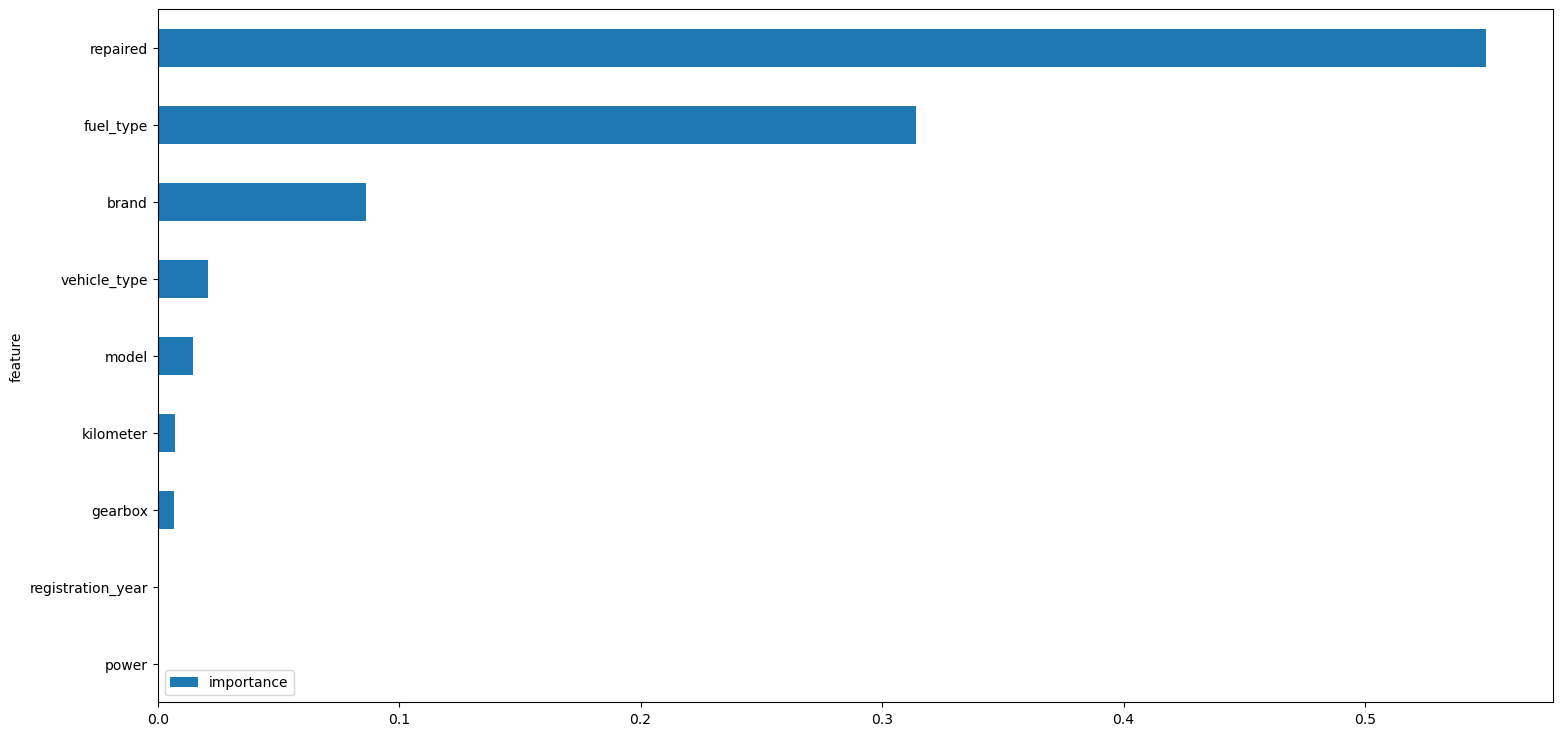

In [150]:
feature_results.sort_values('importance',ascending=True).reset_index(drop=True).plot(x='feature', 
                                                                                     y='importance', 
                                                                                     kind='barh', 
                                                                                     figsize=(18, 9)) 

In [151]:
def feature_importances(model, X, title):
    plt.figure(figsize=(20, 10))
    sns.barplot(x='feature', y='importance', data=feature_results.sort_values('importance',ascending=True).reset_index(drop=True))
    plt.title(title)
    plt.tight_layout()
    plt.show()

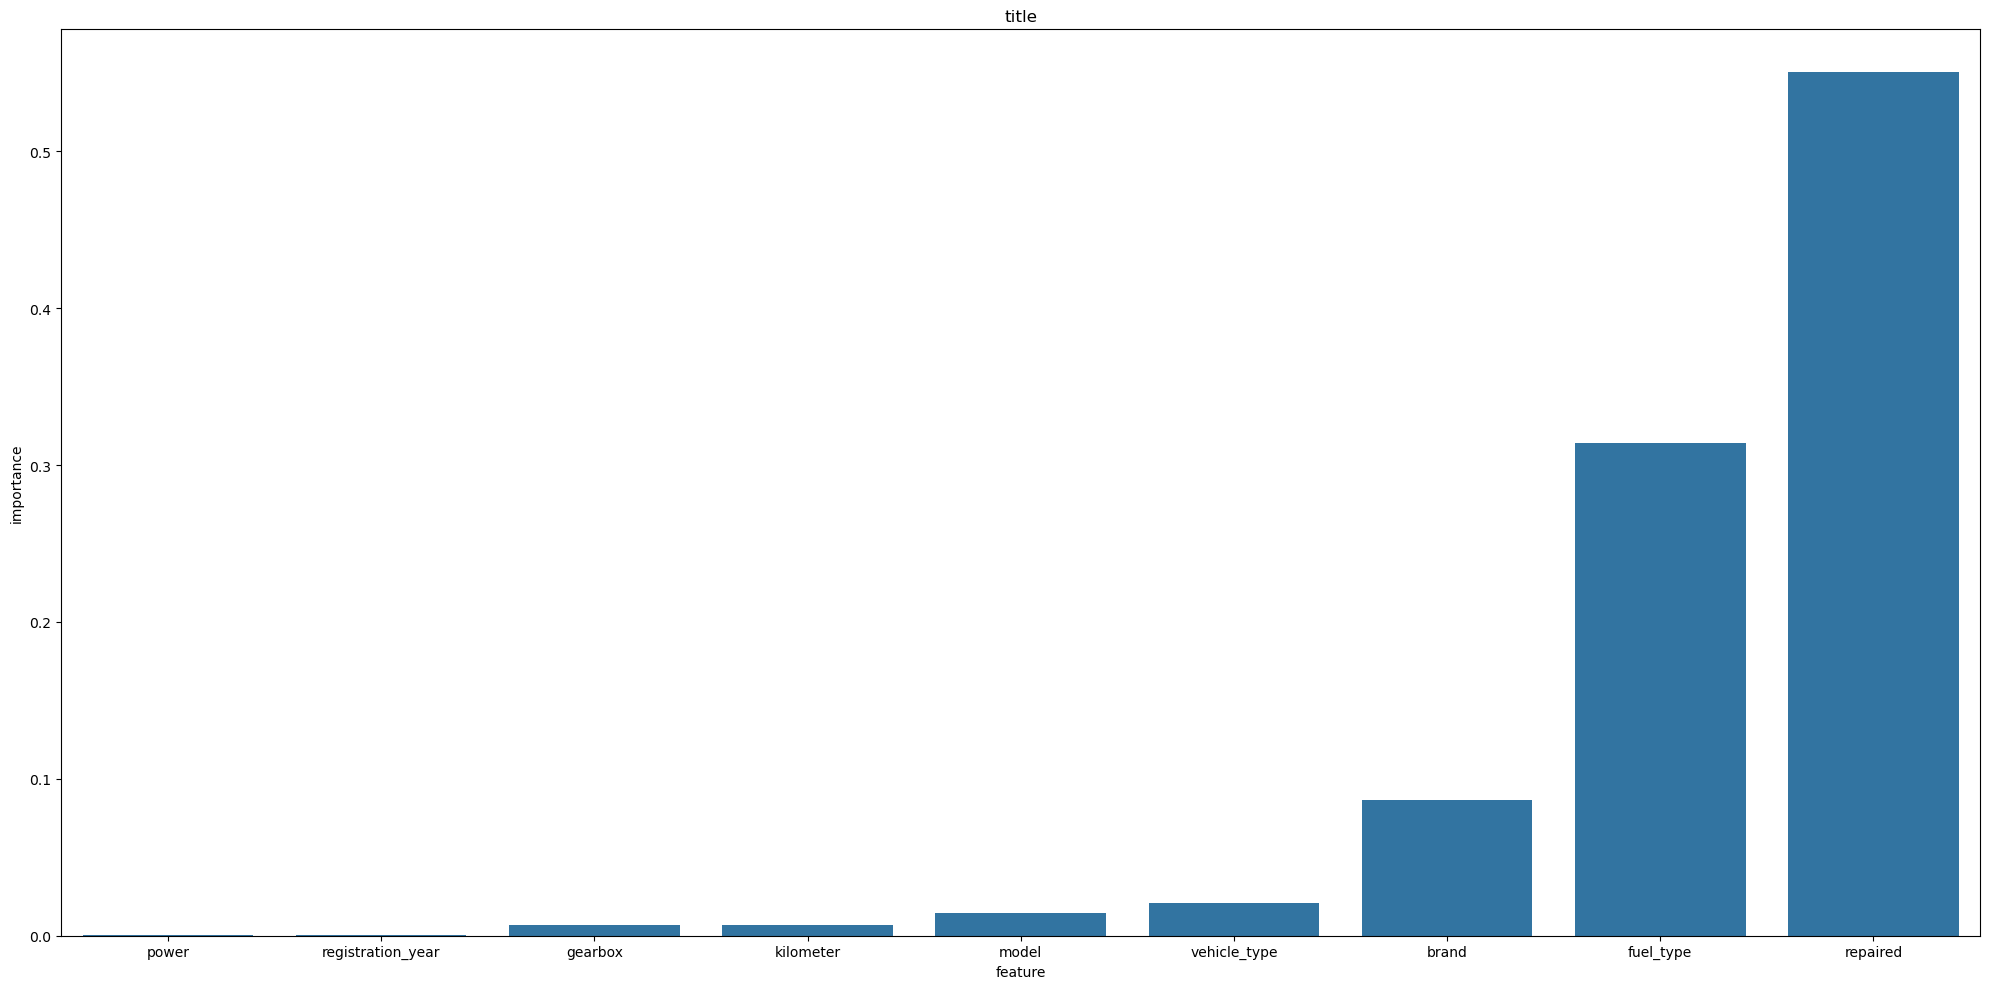

In [152]:
feature_importances(decisiontree_fit, X, 'title')

**Выводы:**

1. В данном проекте были обучены разные модели машинного обучения с использованием разных гиперпараметров. 

2. В соответствии с ТЗ фиксировались: качество предсказания (метрика RMSE меньше 2500), время обучения модели и время предсказания модели. 

3. По скорости предсказания и обучения явно выделяется DecisionTreeRegressor, на втором месте LGBMRegressor, в которой наилучшим образом сбалансирована точность предсказания и скорость работы. Далее идут CatBoostRegressor и XGBRegressor.

4. По итогам моделирования заказчику можно предложить DecisionTreeRegressor. Если критична и важна больше точность модели, а не скорость, то можно предложить XGBRegressor и CatBoostRegressor.

5. Среди наиболее важных признаков, которые использует модель особо выделяются три признака: была ли машина в ремонте, тип топлива и марка автомобиля.

**Тестирование лучшей модели**

In [153]:
decisiontree_rmse = mean_squared_error(predictions_model_2, y_test) ** 0.5
print(f'RMSE лучшей модели на тестовой выборке выборке: {decisiontree_rmse}')

RMSE лучшей модели на тестовой выборке выборке: 2066.358312272865


По итогам RMSE на тесте составил 2066.3, что соответствует условиям задачи и метрике не более 2500.

## Чек-лист проверки

Поставьте 'x' в выполненных пунктах. Далее нажмите Shift+Enter.

- [x]  Jupyter Notebook открыт
- [ ]  Весь код выполняется без ошибок
- [ ]  Ячейки с кодом расположены в порядке исполнения
- [ ]  Выполнена загрузка и подготовка данных
- [ ]  Выполнено обучение моделей
- [ ]  Есть анализ скорости работы и качества моделей